https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook

https://towardsdatascience.com/how-to-efficiently-implement-area-under-precision-recall-curve-pr-auc-a85872fd7f14

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from scipy import stats
from scipy.special import boxcox, inv_boxcox

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif

import time
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import _tree
from sklearn import tree

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

from bayes_opt import BayesianOptimization

from sklearn import metrics

import shap

### Dictionaries

In [2]:
ed_dict = {1:'Below college',
           2:'College',
           3:'Bachelor',
           4:'Master',
           5:'Doctor'}
env_sat_dict = {1:'Low',
                2:'Medium',
                3:'High',
                4:'Very high'}
prat_dict = {1:'Low',
             2:'Good',
             3:'Excellent',
             4:'Outstanding'}
wlivb_dict = {1:'Bad',
             2:'Good',
             3:'Better',
             4:'Best'}



### Functions

In [3]:
################
### Features ###
################

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [4]:
def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]            
        
    return rules, proba

In [5]:
def new_f(new_name, name, var, cvar):
    X_train[new_name] = 0
    X_train.loc[X_train[cvar] == name, new_name] = X_train[var]
    X_test[new_name] = 0
    X_test.loc[X_test[cvar] == name, new_name] = X_test[var]

In [6]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [7]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [8]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [9]:
#######################
### Model selection ###
#######################

def select_model(X, y, pipeline=None):
    """Test a range of classifiers and return their performance metrics on training data.

    Args:
        X (object): Pandas dataframe containing X_train data.
        y (object): Pandas dataframe containing y_train data.
        pipeline (object): Pipeline from get_pipeline().

    Return:
        df (object): Pandas dataframe containing model performance data.
    """

    classifiers = {}
    classifiers.update({"DummyClassifier": DummyClassifier(strategy='most_frequent')})
    classifiers.update({"LGBMClassifier": LGBMClassifier()})
    classifiers.update({"ExtraTreeClassifier": ExtraTreeClassifier()})
    classifiers.update({"RidgeClassifier": RidgeClassifier()})
    classifiers.update({"BernoulliNB": BernoulliNB()})
    classifiers.update({"SGDClassifier": SGDClassifier()})
    classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})     
    classifiers.update({"CatBoostClassifier":CatBoostClassifier(silent=True)})    
    classifiers.update({"XGBClassifier": XGBClassifier(use_label_encoder=False,
                                                       eval_metric='logloss',
                                                       objective='binary:logistic',
                                                     )})    
    classifiers.update({"DecisionTreeClassifier": DecisionTreeClassifier()})

    # Stacking
    models = []

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))

    # classifiers.update({"VotingClassifier (XGBClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('LGBMClassifier', LGBMClassifier()))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
    # classifiers.update({"VotingClassifier (XGBClassifier, LGBMClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('RandomForestClassifier', RandomForestClassifier()))
    # models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, RandomForestClassifier, DecisionTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('AdaBoostClassifier', AdaBoostClassifier()))
    # models.append(('ExtraTreeClassifier', ExtraTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, AdaBoostClassifier, ExtraTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, ExtraTreesClassifier)": VotingClassifier(models)})

    #scoring = {'f1_score' : make_scorer(f1_score, average='weighted')}

    df_models = pd.DataFrame(columns=['model', 'run_time', 'accuracy'])
    
    for key in tqdm(classifiers):
        start_time = time.time()
        #pipeline = get_pipeline(X, classifiers[key])        

        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), classifiers[key]) 

        cv = cross_val_score(pipeline, X, y, cv=5, scoring = 'roc_auc')
        row = {'model': key,
               'run_time': format(round((time.time() - start_time)/60,2)),
               'accuracy': cv.mean(),
        }
        row_df = pd.DataFrame(row, index=[0])

        df_models = pd.concat([df_models,
                                   row_df],
                                  axis=0,
                                  ignore_index=True)

        df_models = df_models.sort_values(by='accuracy', ascending=False)
    return df_models



In [10]:
######################################
### Catboost Hyperparameter tuning ###
######################################

def CB_opt(n_estimators, depth, learning_rate, max_bin,
    subsample, num_leaves, l2_leaf_reg, model_size_reg):
    catb_scores = []
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
    for train_index, test_index in skf.split(X_train_mod, y_train):

        trainx, valx = X_train_mod.iloc[train_index], X_train_mod.iloc[test_index]
        trainy, valy = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]    
        
        reg = CatBoostClassifier(verbose = 0,
                               n_estimators = int(n_estimators),
                               learning_rate = learning_rate,
                               subsample = subsample,
                               l2_leaf_reg = l2_leaf_reg,
                               max_depth = int(depth),
                               num_leaves = int(num_leaves),
                               random_state = 88,
                               grow_policy = "Lossguide",
                               max_bin = int(max_bin),
                               use_best_model = True,
                               model_size_reg = model_size_reg,
                               eval_metric = 'AUC'

                               )
        pipeline_reg = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), reg) 
        pipeline_reg.fit(trainx, trainy, eval_set = (valx, valy))        
    
      #reg.fit(trainx, trainy, eval_set = (valx, valy))
        catb_scores.append(roc_auc_score(valy, reg.pipeline_reg(valx)))
    return np.mean(catb_scores)

In [11]:
#################
### XGB Boost ###
#################

def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma):

    estimator_function = xgb.XGBClassifier(max_depth = int(max_depth),
                                               learning_rate = learning_rate,
                                               n_estimators = int(n_estimators),
                                               reg_alpha = reg_alpha,
                                               gamma = gamma,
                                               reg_lambda = reg_lambda,
                                               nthread = -1,
                                               objective = "binary:logistic",
                                               eval_metric = "auc",
                                               seed = seed)
    # Fit the estimator
    estimator_function.fit(X_train_mod, y_train)

    # calculate out-of-the-box roc_score using validation set 1
    probs = estimator_function.predict_proba(X_train_mod)
    probs = probs[:,1]
    val1_roc = roc_auc_score(y_train,probs)

    # calculate out-of-the-box roc_score using validation set 2
    probs = estimator_function.predict_proba(X_test)
    probs = probs[:,1]
    val2_roc = roc_auc_score(y_test,probs)

    # return the mean validation score to be maximized
    return np.array([val1_roc,val2_roc]).mean()

In [12]:
##################
### LGBM model ###
##################

def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):

    params = {'application':'binary', 'metric':'auc'}
    params['learning_rate'] = max(min(learning_rate, 1), 0)
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['max_bin'] = int(round(max_depth))
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['subsample'] = max(min(subsample, 1), 0)

    cv_result = lgb.cv(params,
                           train_data,
                           nfold = 10,
                           seed = 6,
                           stratified = True,
                           verbose_eval = 200,
                           metrics = ['auc'])
    return max(cv_result['auc-mean'])

In [13]:
########################
### Confusion matrix ###
########################

def cm2df(cm, labels):
            df = pd.DataFrame()

            for i, row_label in enumerate(labels):
                rowdata={}
        
                for j, col_label in enumerate(labels): 
                    rowdata[col_label]=cm[i,j]
                df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
            return df[labels]

## Read in the data

In [14]:
data = pd.read_csv("creditcard.csv")
print(data.shape)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [16]:
print(list(data.columns))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [17]:
nonvar_lst = []

for i in range(data.shape[1]):
    print('Column: ', data.columns[i], ', number of unique classes: ', data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print('Values: ', list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])

Column:  Time , number of unique classes:  124592
Column:  V1 , number of unique classes:  275663
Column:  V2 , number of unique classes:  275663
Column:  V3 , number of unique classes:  275663
Column:  V4 , number of unique classes:  275663
Column:  V5 , number of unique classes:  275663
Column:  V6 , number of unique classes:  275663
Column:  V7 , number of unique classes:  275663
Column:  V8 , number of unique classes:  275663
Column:  V9 , number of unique classes:  275663
Column:  V10 , number of unique classes:  275663
Column:  V11 , number of unique classes:  275663
Column:  V12 , number of unique classes:  275663
Column:  V13 , number of unique classes:  275663
Column:  V14 , number of unique classes:  275663
Column:  V15 , number of unique classes:  275663
Column:  V16 , number of unique classes:  275663
Column:  V17 , number of unique classes:  275663
Column:  V18 , number of unique classes:  275663
Column:  V19 , number of unique classes:  275663
Column:  V20 , number of uni

In [18]:
nonvar_lst

[]

## Missing data

In [19]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/data.shape[0]*100
check

,Count,perc
Time,0,0.0
V1,0,0.0
V2,0,0.0
V3,0,0.0
V4,0,0.0
V5,0,0.0
V6,0,0.0
V7,0,0.0
V8,0,0.0
V9,0,0.0


## Target variable

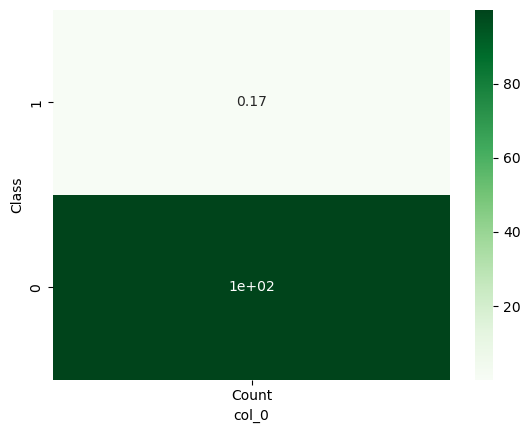

In [20]:

room_t = pd.DataFrame(pd.crosstab(data.Class, columns = 'Count', normalize='columns'))
room_t = room_t * 100

ax = sns.heatmap(room_t, annot = True, cmap="Greens")
ax.invert_yaxis()

In [21]:
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


## Adjust the training set

In [22]:
data = data.drop_duplicates()
print(data.shape)

(283726, 31)


Ignoring `palette` because no `hue` variable has been assigned.


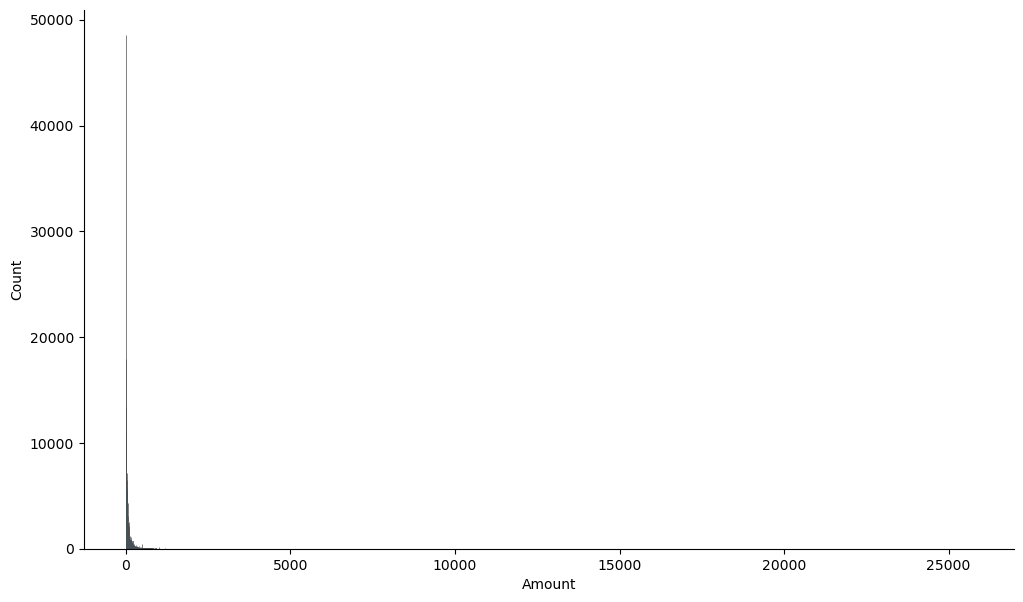

In [23]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    data,
    x="Amount", 
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Amount")
plt.show();

Ignoring `palette` because no `hue` variable has been assigned.


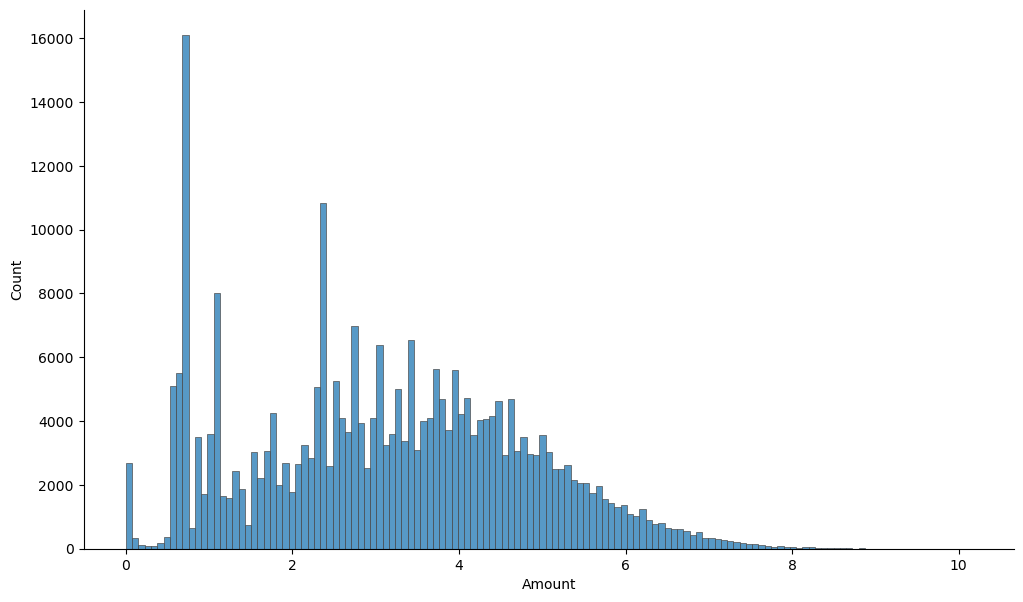

In [24]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

data['Log_Amount'] = np.log(data['Amount'] + 1)

sns.histplot(
    data,
    x="Log_Amount", 
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Amount")
plt.show();

In [25]:
data = data.drop(['Amount'], axis = 1)

Ignoring `palette` because no `hue` variable has been assigned.


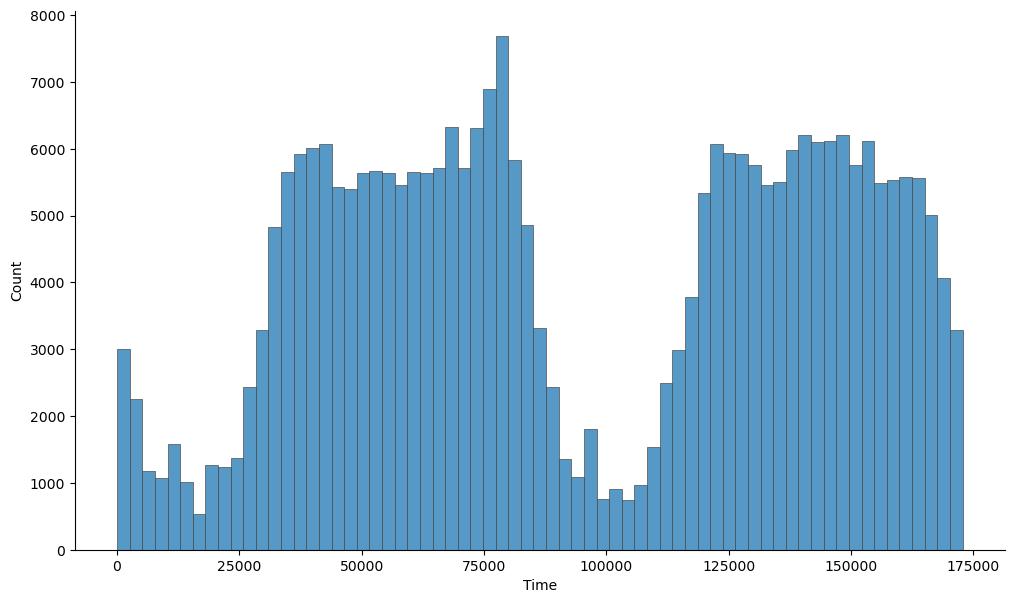

In [26]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    data,
    x="Time", 
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Time")
plt.show();

In [27]:
# V14       0.007855
# V17       0.007755
# V12       0.007517
# V10       0.007277
# V11       0.006708
# V16       0.005745

## Numerical data

In [28]:
num_cols = list(data.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
print(num_cols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Log_Amount']


In [29]:
num_cols.remove('Class')

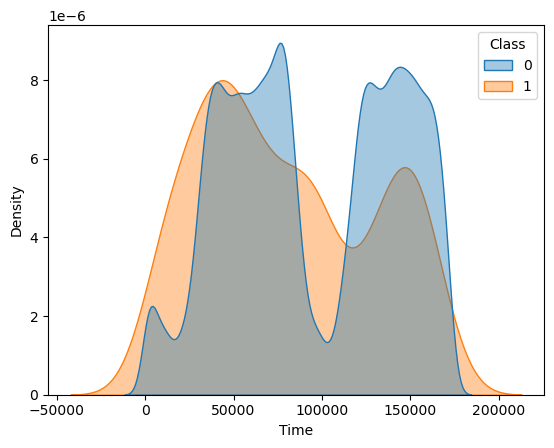

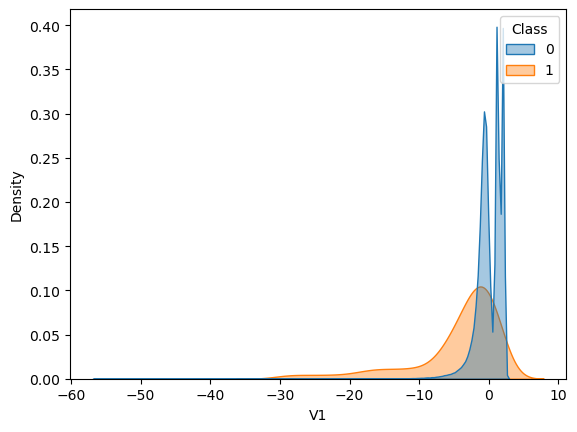

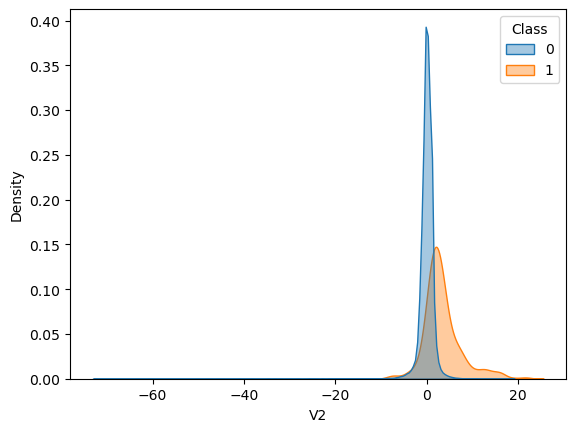

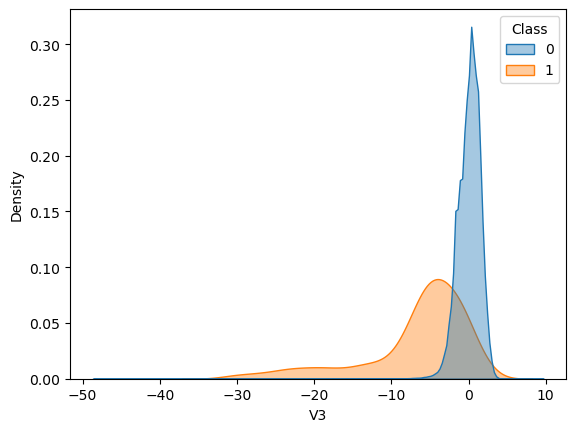

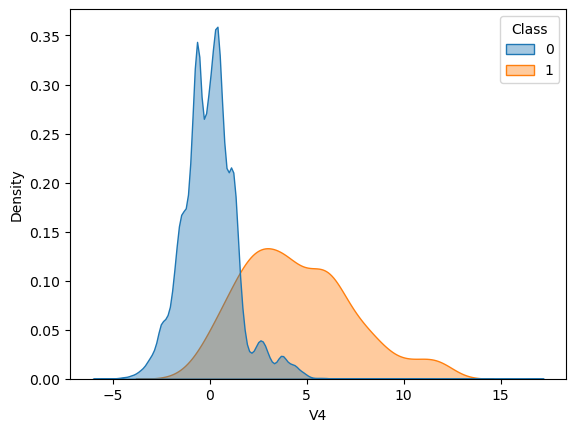

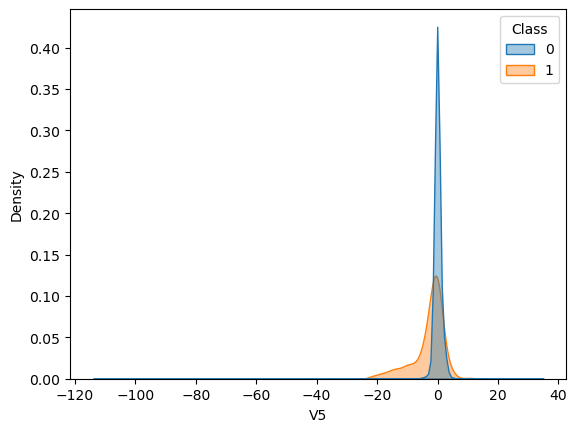

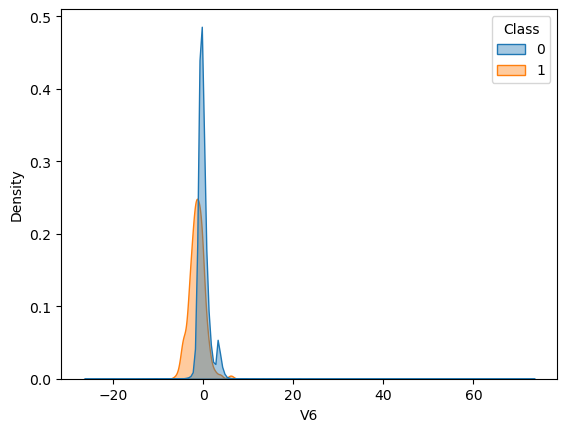

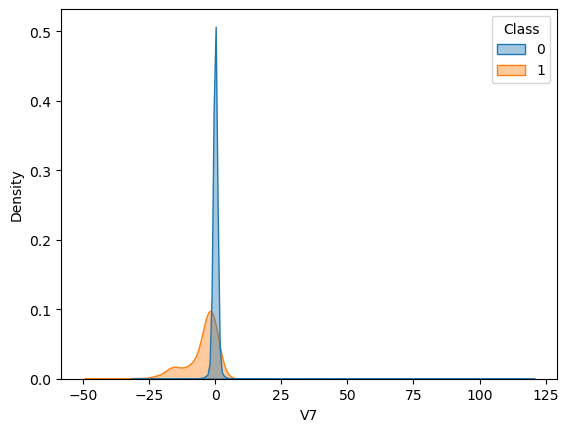

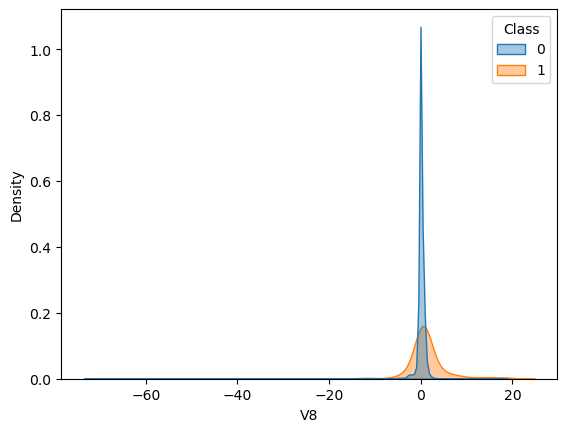

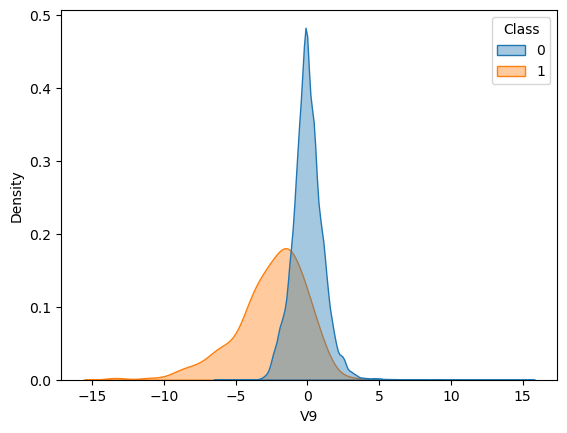

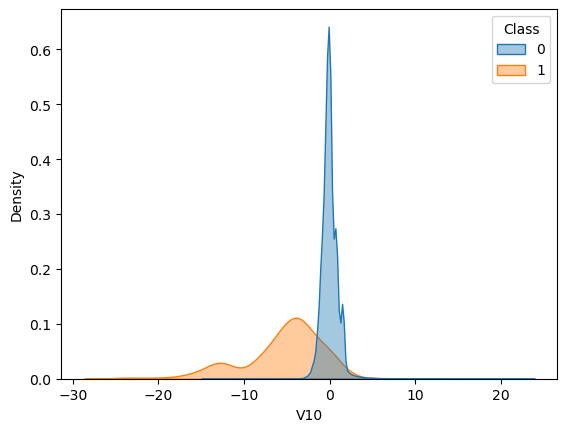

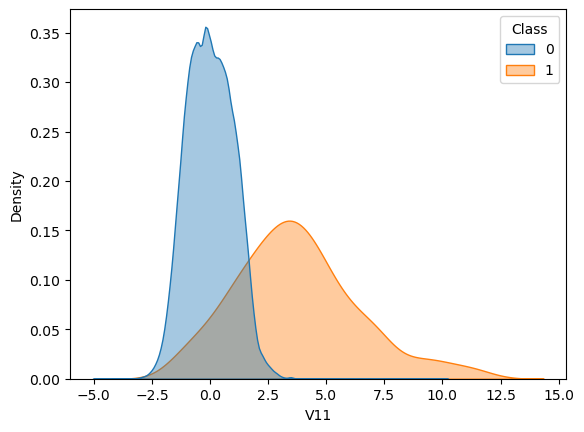

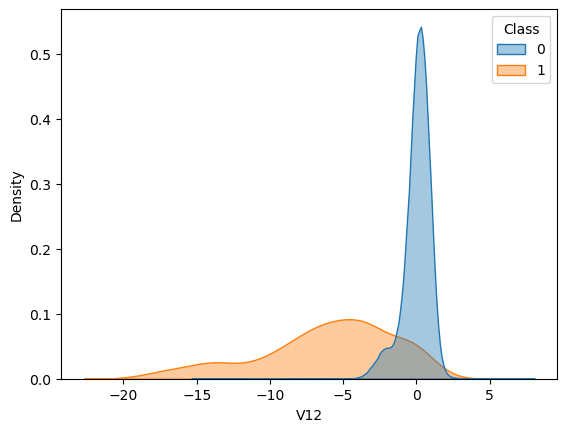

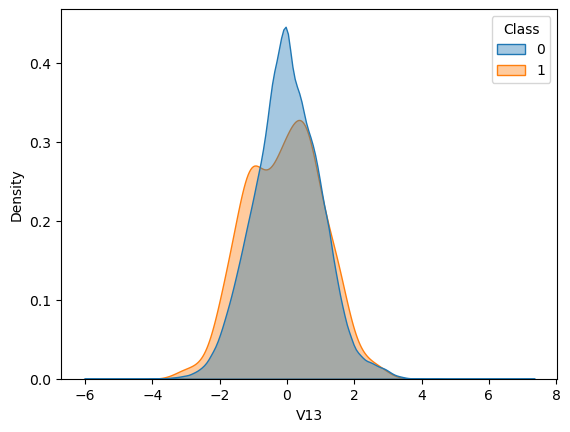

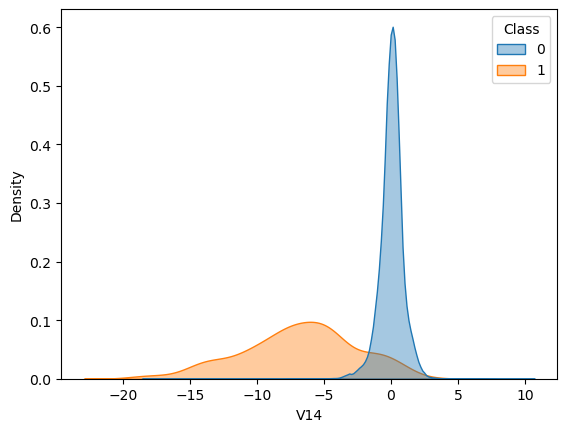

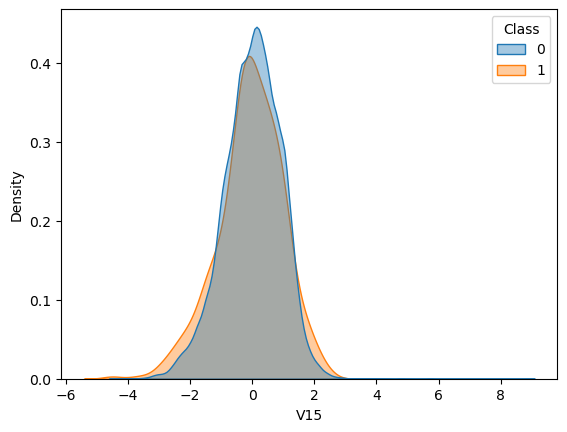

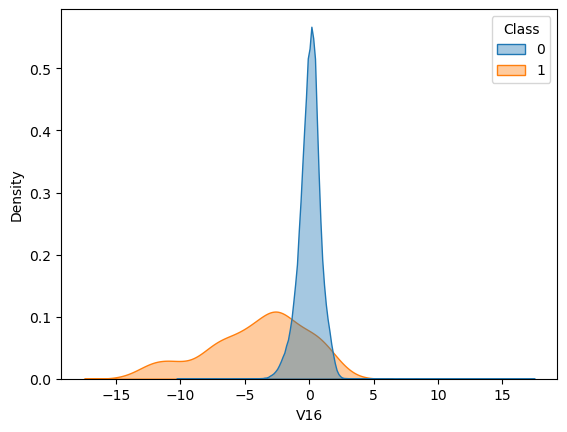

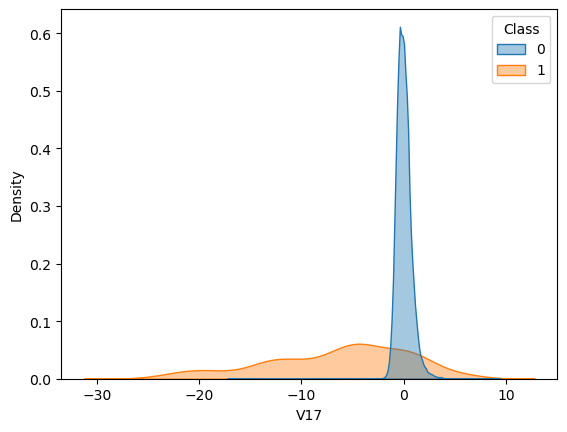

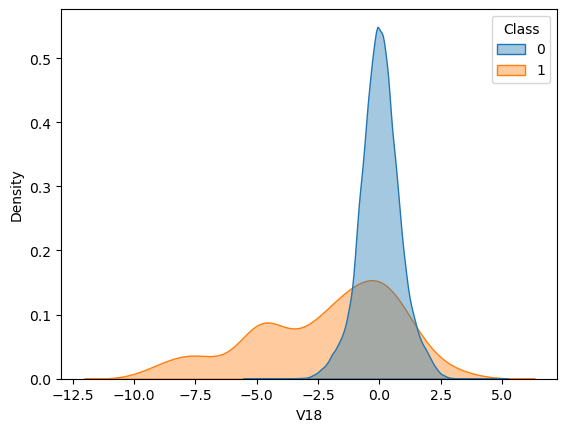

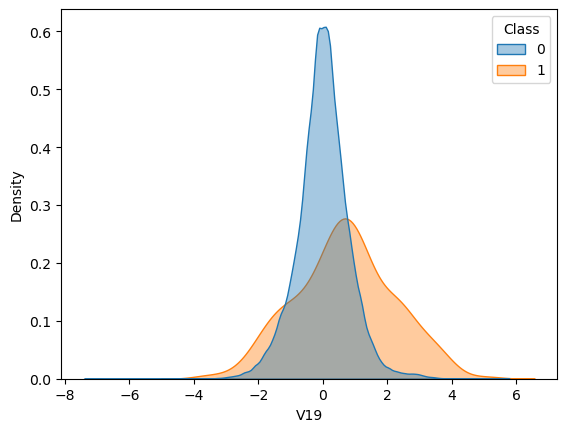

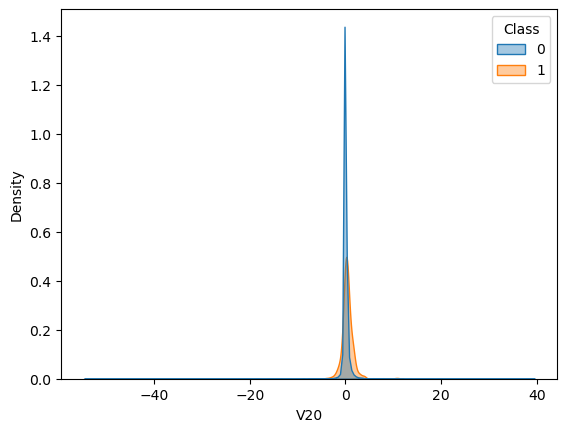

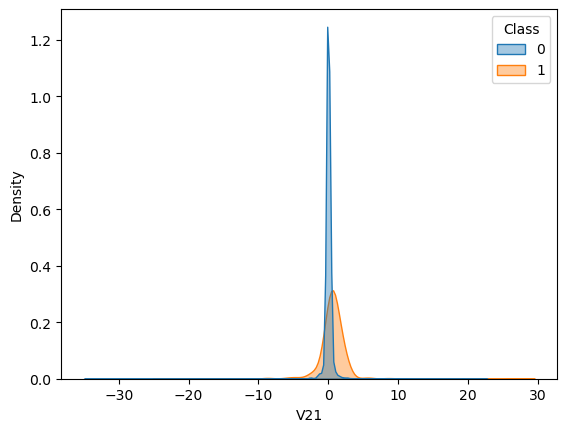

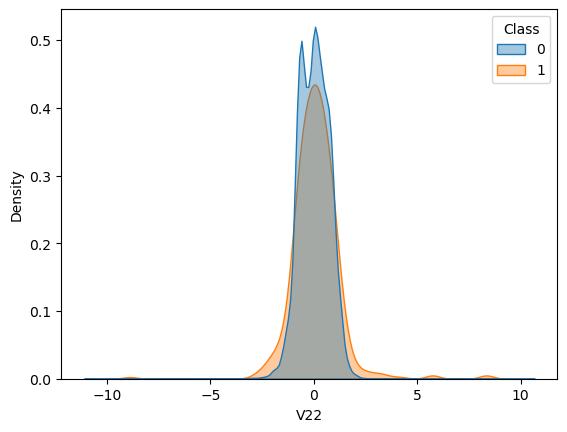

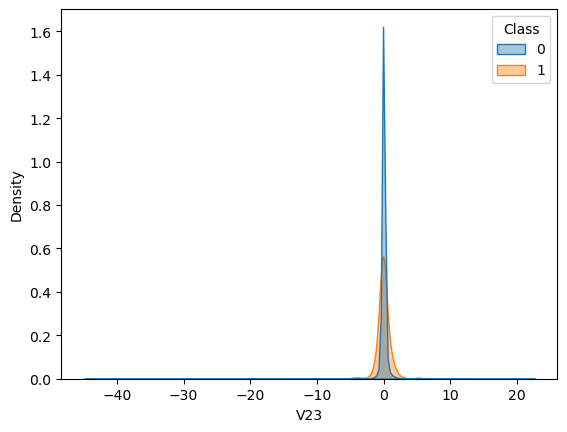

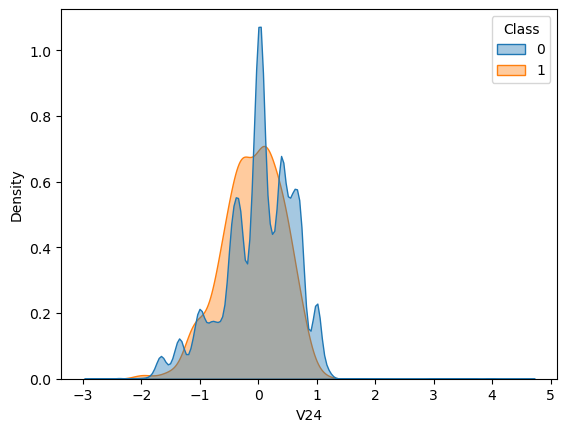

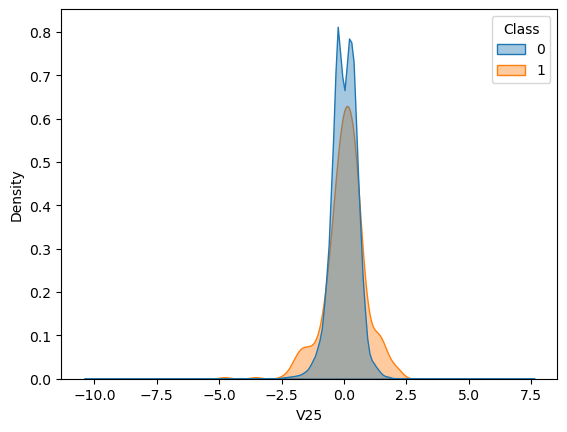

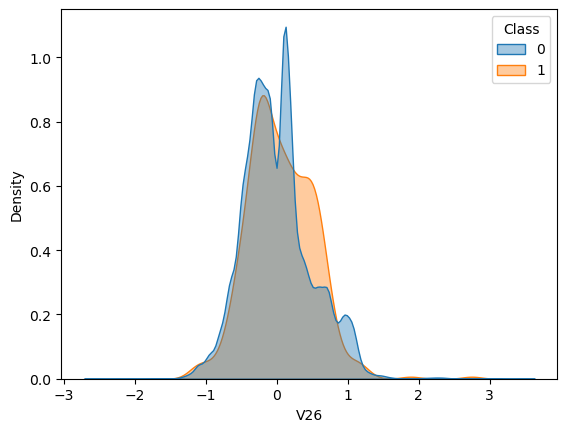

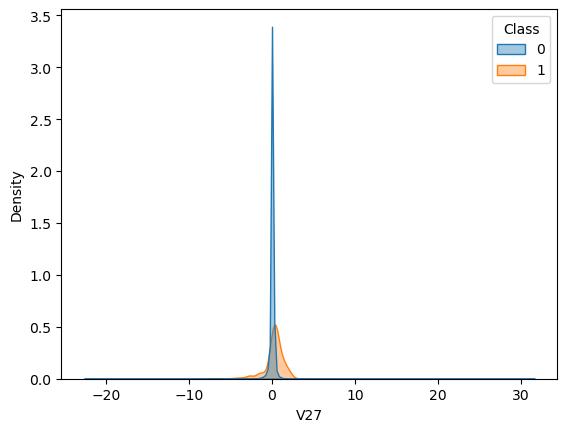

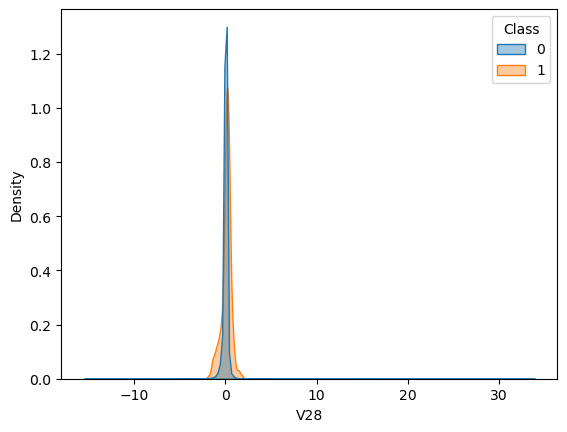

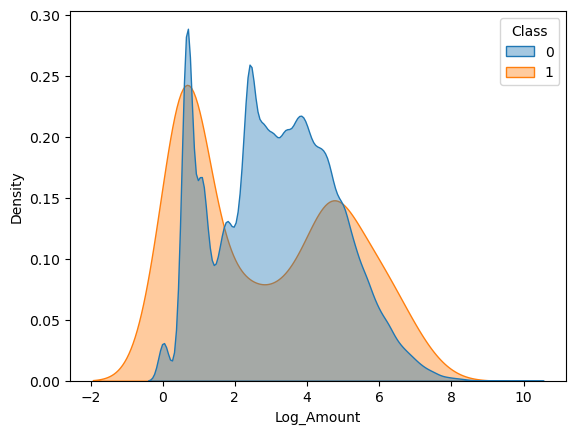

In [30]:
for name in num_cols:
    sns.kdeplot(data=data, x=name, hue="Class", fill=True, common_norm=False, alpha=0.4)
    plt.show()

### Interactions

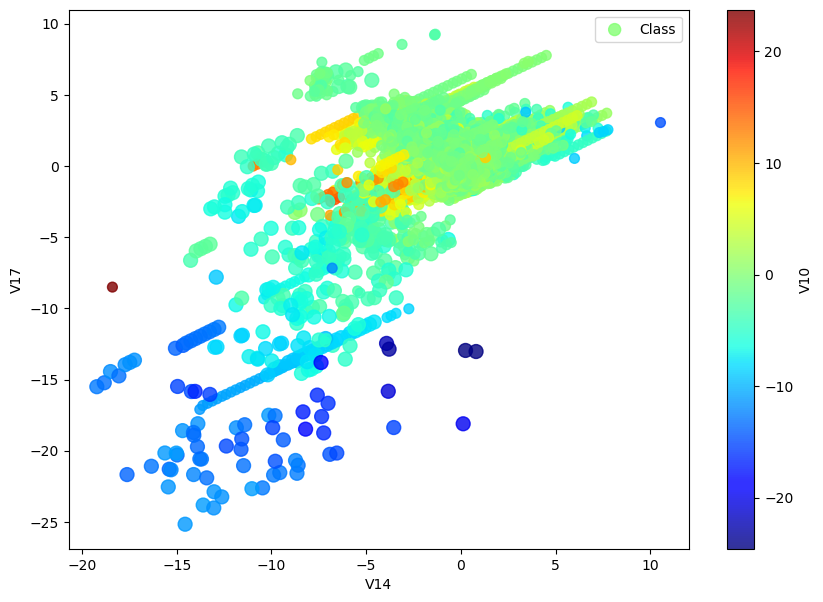

In [31]:
# V14       0.007855
# V17       0.007755
# V12       0.007517
# V10       0.007277

data["Classa"] = (data["Class"] + 1) * 50

data.plot(kind="scatter", x="V14", y="V17", alpha=0.8,
             s=data["Classa"], label="Class", figsize=(10,7),
             c="V10", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show();
data = data.drop(['Classa'], axis = 1)

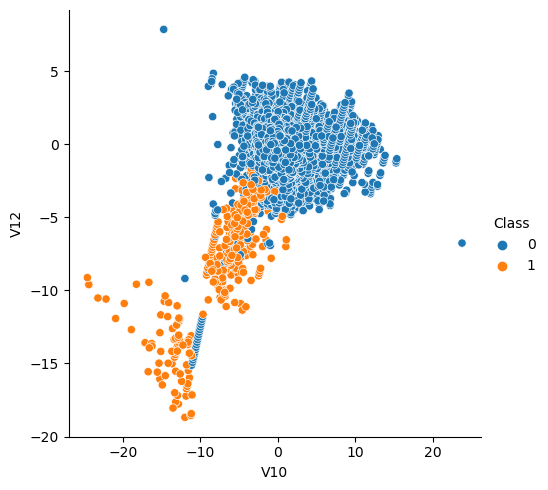

In [32]:
sns.relplot(x='V10',
            y='V12',
            data = data,
            kind='scatter',
            hue='Class')
plt.ylabel("V12")
plt.xlabel("V10")
plt.show();

In [33]:
#num_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',  'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',  'YearsWithCurrManager']
#sns.pairplot(data[num_cols + ['Class']], hue = 'Class')
#plt.show()

## Categorial data

In [34]:
cat_cols = list(data.select_dtypes(include=['object']))
cat_colshttp://localhost:8888/notebooks/Desktop/Ks/Python%20code/Kaggle/Credit%20Fraud/Credit%20fraud.ipynb#Test/Train-split

[]

## Test/Train split

In [35]:
print(list(data.columns))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Log_Amount']


In [36]:
y = data.Class
X = data.drop(['Class'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.4,
                                                    stratify = y,
                                                    random_state = 222)

print(X_train.shape, X_test.shape)
# (64215, 34) (42811, 34)

print('Fraud rate train (%): ', round(y_train[y_train == 1].shape[0]/y_train.shape[0]*100,2))
print('Fraud rate test (%): ', round(y_test[y_test == 1].shape[0]/y_test.shape[0]*100,2))

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

(170235, 30) (113491, 30)
Fraud rate train (%):  0.17
Fraud rate test (%):  0.17


In [37]:
#print(list(X_train.columns))

## Examine the features

In [38]:
y = y_train.copy()
X = X_train.copy()

#X.duration_bin = X.duration_bin.astype(object)

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
discrete_features = X.dtypes == int

In [39]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

V17           0.007739
V14           0.007576
V12           0.007090
V10           0.007045
V11           0.006480
V16           0.005775
V4            0.004517
V3            0.004434
V9            0.003893
V7            0.003820
V18           0.003743
V2            0.002765
V21           0.002299
V6            0.002084
V27           0.002063
V5            0.001974
V1            0.001773
V28           0.001760
V8            0.001503
Time          0.001346
Log_Amount    0.001337
V19           0.000956
V20           0.000910
V23           0.000741
V24           0.000415
V26           0.000275
V25           0.000264
V22           0.000167
V13           0.000000
V15           0.000000
Name: MI Scores, dtype: float64

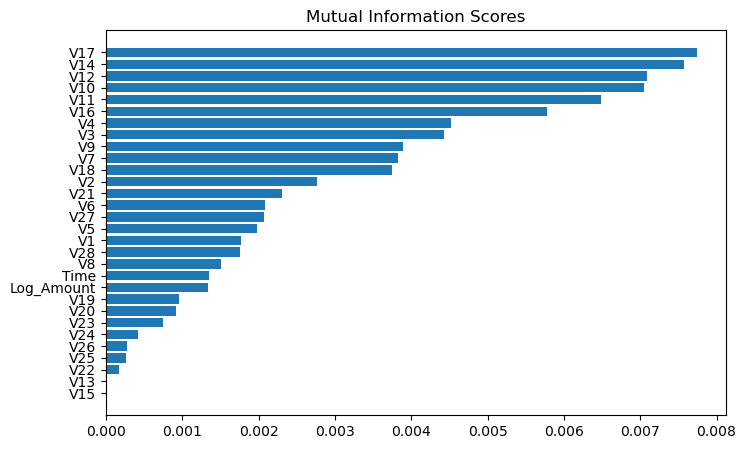

In [40]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.show();

## Features from tree classification

In [41]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
print(num_cols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Log_Amount']


In [42]:
X = X_train[num_cols]
y = y_train

clf = DecisionTreeClassifier(max_depth=5, random_state=1234)
model = clf.fit(X, y)

In [43]:
text_representation = tree.export_text(clf, feature_names=list(X.columns))
#print(text_representation)

In [44]:
rule_lst = []
flattened_lst = []

minutes = 0.01
t_end = time.time() + 60 * minutes

while time.time() < t_end:
    rules, proba = get_rules(clf, list(X.columns), [0,1], 80, 100)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

In [45]:
flattened_lst

['if (V17 <= -2.754) and (V7 <= 0.388) and (V14 <= -2.896) and (V27 <= 1.01) and (V4 > -0.119) then class: 1 (proba: 97.12%) | based on 139 samples',
 'if (V17 > -2.754) and (V12 > -4.98) and (V14 > -4.661) and (V14 > -4.25) and (V4 > 4.821) then class: 0 (proba: 99.11%) | based on 448 samples',
 'if (V17 > -2.754) and (V12 > -4.98) and (V14 > -4.661) and (V14 > -4.25) and (V4 <= 4.821) then class: 0 (proba: 99.98%) | based on 169,296 samples']

## New features

In [46]:
for i, dset in enumerate([X_train,X_test]):

    dseta = dset.copy()
    dseta['feature_1'] = 0
    dseta.loc[(dseta.V17 <= -2.754) & 
            (dseta.V12 <= -2.37) & 
            (dseta.V3 <= -0.851) & 
            (dseta.V26 > -0.264) &
            (dseta.V11 > 1.105), 'feature_1'] = 1

    dseta['feature_2'] = 0
    dseta.loc[(dseta.V17 > -2.754) &
            (dseta.V14 > -7.755) & 
            (dseta.V12 > -5.437) &
            (dseta.V23 > -15.563), 'feature_2'] = 1

    dseta['feature_3'] = 0
    dseta.loc[(dseta.V17 > -2.754) & 
            (dseta.V14 > -7.755) & 
            (dseta.V14 <= -4.661) & 
            (dseta.V10 > -1.847) &
            (dseta.V4 <= 5.231), 'feature_3'] = 1
    if i == 0:
        X_train = dseta
    elif i == 1:
        X_test = dseta

## Binning data

In [47]:
m_val_lst = ['Time','V2','V3','V20','V21']

for m_val in m_val_lst:
    X_train[m_val + '_bin'], bin_edges  = pd.qcut(X_train[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train[m_val + '_bin']  = pd.cut(X_train[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train[m_val + '_bin']  = X_train[m_val + '_bin'].astype(str)
    X_train.loc[X_train[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

    ### Test data ###
    X_test[m_val + '_bin'] = pd.cut(X_test[m_val],
                                    bins = bin_edges,
                                    labels = range(len(bin_edges)-1),
                                    include_lowest=True)
    
    X_test[m_val + '_bin'] = X_test[m_val + '_bin'].astype('str')
    X_test.loc[X_test[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'
    


Time [     0.   35019.8  47676.   60630.2  73185.6  84595.  120319.4 132950.
 145272.  157616.2 172788. ] range(0, 10)
V2 [-7.27157276e+01 -1.36226742e+00 -7.89099068e-01 -4.34802690e-01
 -1.53025196e-01  6.52283901e-02  2.99852836e-01  6.33087571e-01
  9.53220118e-01  1.31833618e+00  2.14672030e+01] range(0, 10)
V3 [-48.32558936  -1.80153267  -1.16952652  -0.61896617  -0.1975564
   0.18108006   0.49682556   0.8429572    1.21476732   1.67562683
   9.38255843] range(0, 10)
V20 [-5.44977205e+01 -3.87422082e-01 -2.50158347e-01 -1.77736527e-01
 -1.20667084e-01 -6.22078460e-02  4.61915407e-03  8.33677706e-02
  1.94502324e-01  4.40353414e-01  2.62373908e+01] range(0, 10)
V21 [-3.48303821e+01 -3.67752786e-01 -2.66440529e-01 -1.88034221e-01
 -1.06719732e-01 -2.97721076e-02  4.99640297e-02  1.37452619e-01
  2.34440062e-01  3.75932908e-01  2.26148894e+01] range(0, 10)


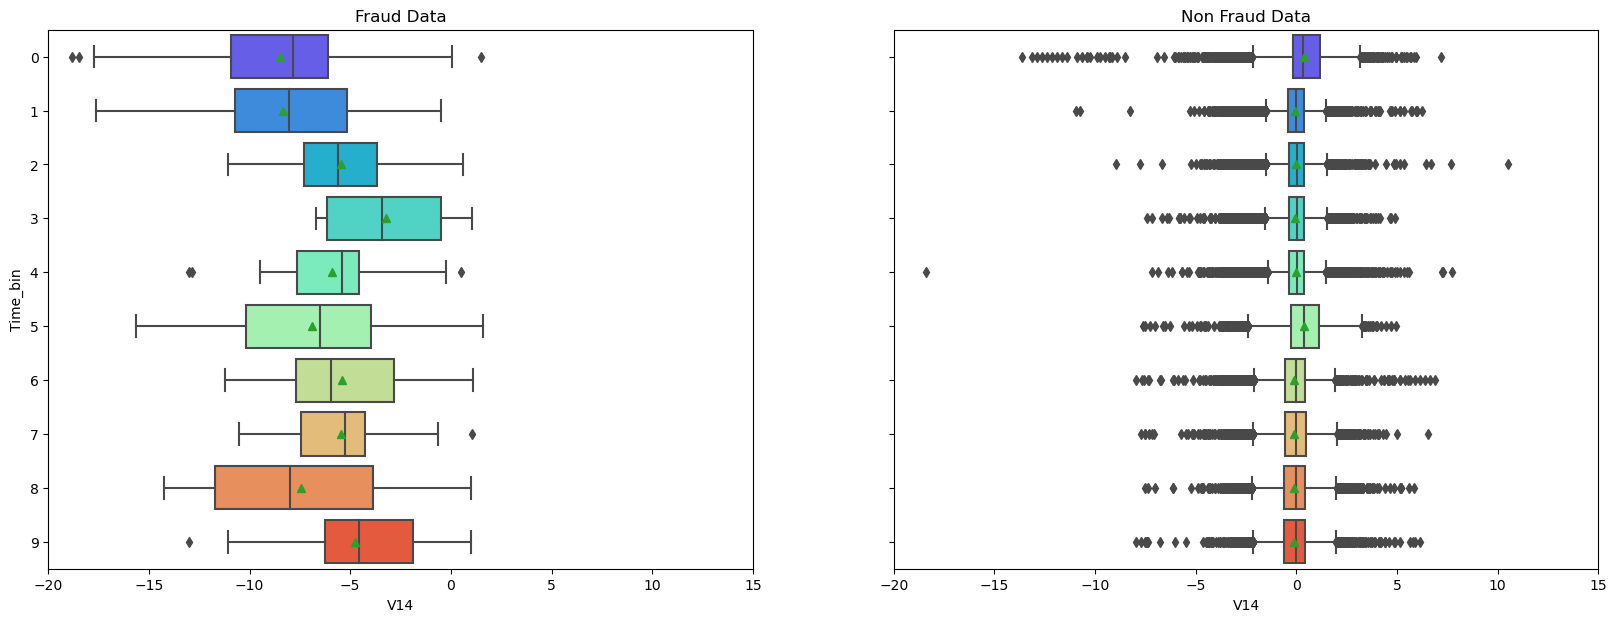

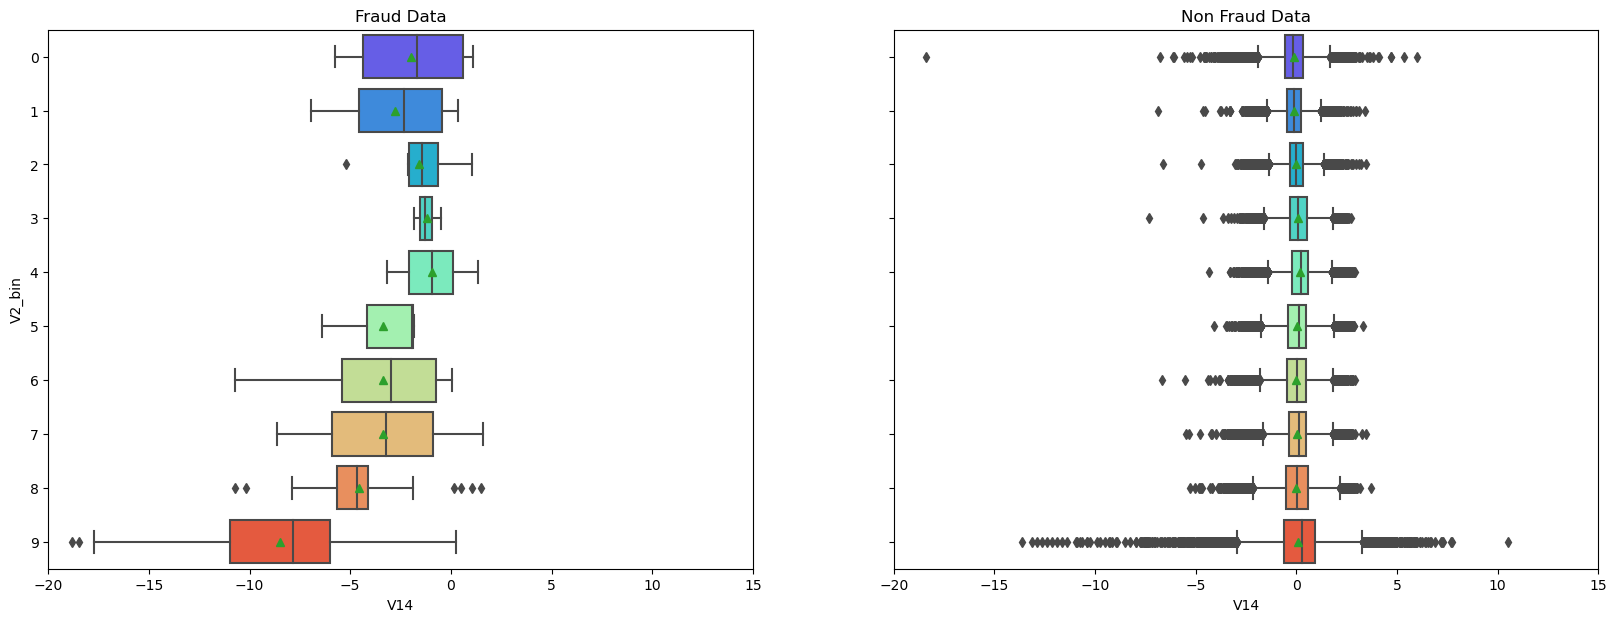

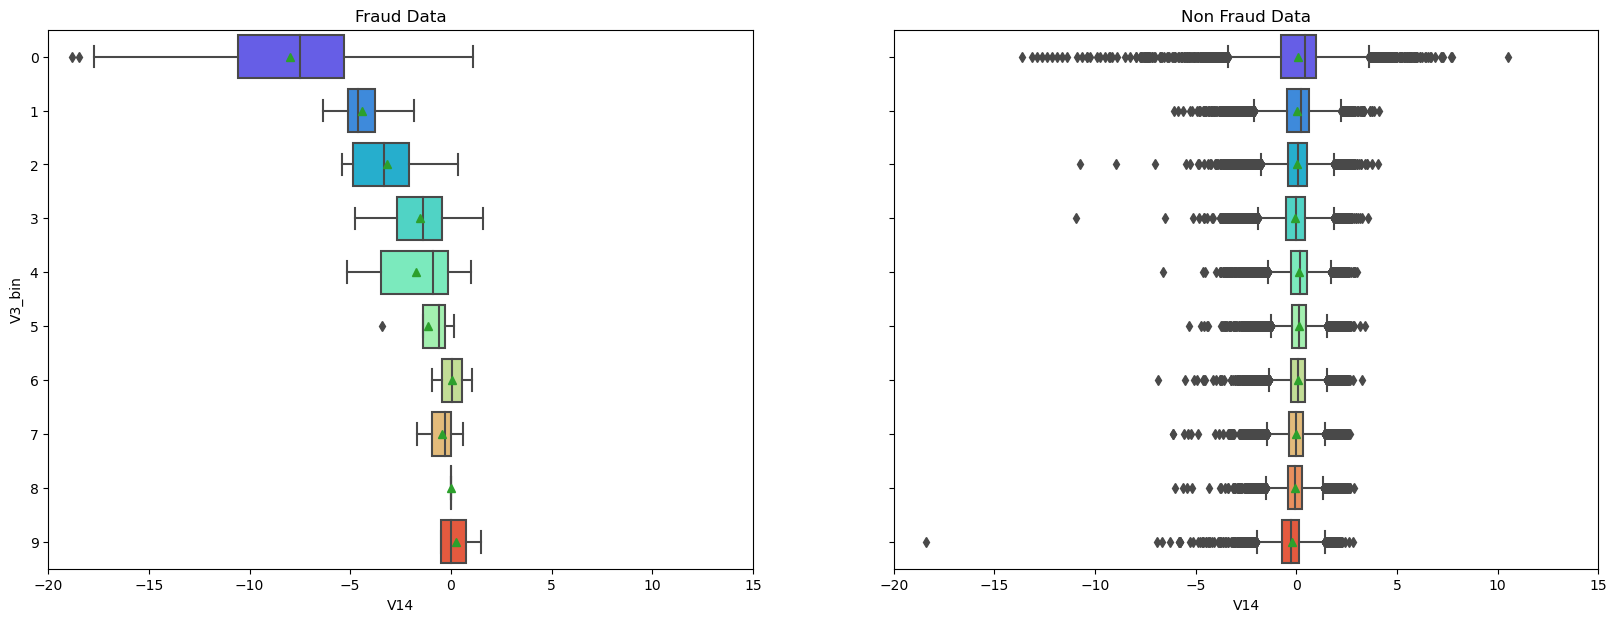

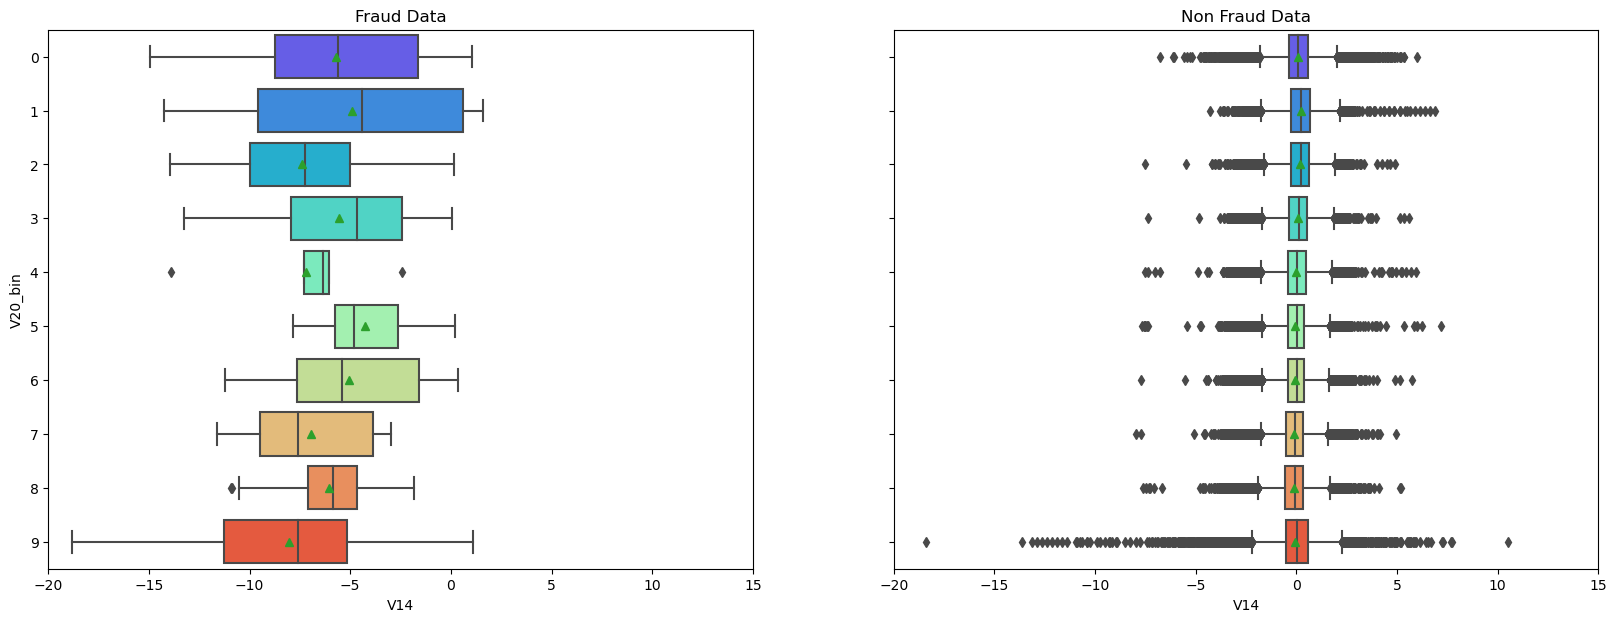

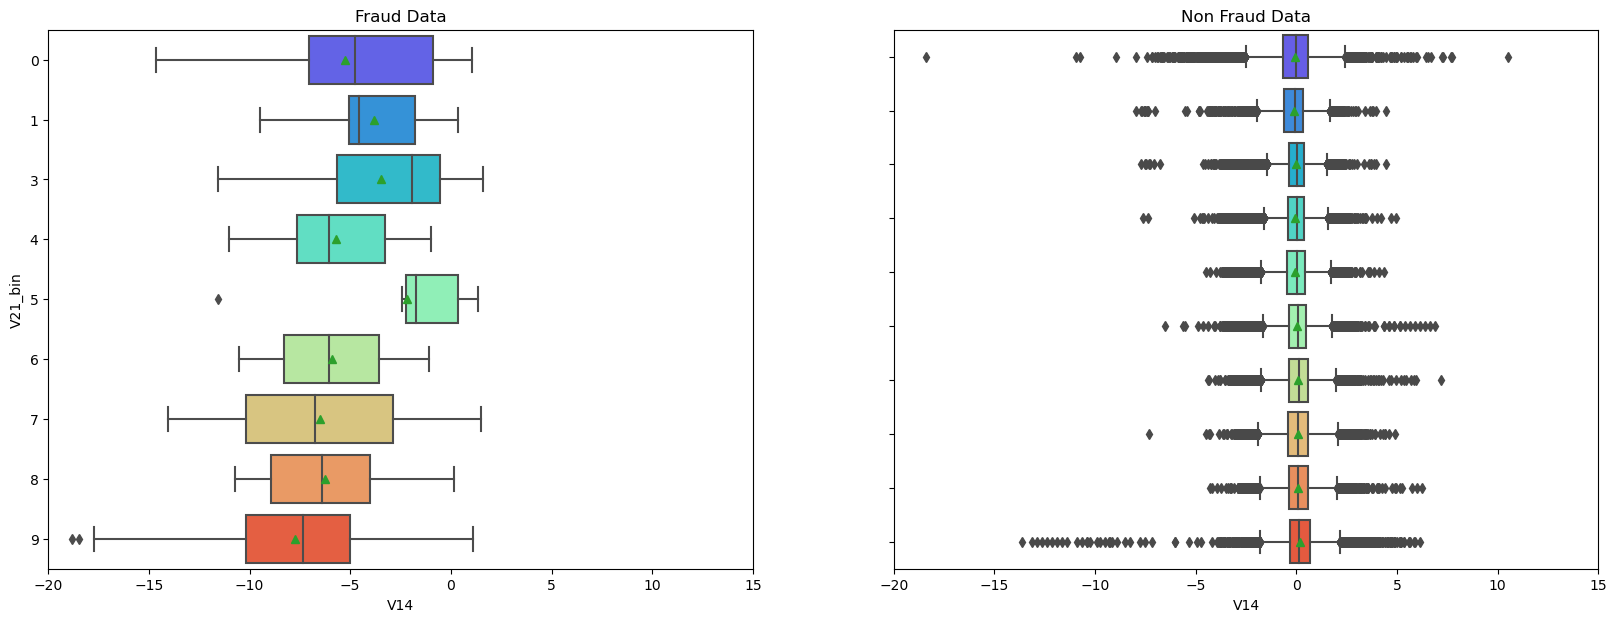

In [48]:
re_data = pd.concat([X_train,y_train], axis = 1)

for name in ["Time_bin", "V2_bin", "V3_bin", "V20_bin", "V21_bin"]:
    df = re_data.copy()
    fig, ax=plt.subplots(1, 2, figsize=(20, 7))
    d1 = df[df.Class == 1]
    d1 = d1.sort_values([name])
    d2 = df[df.Class == 0]
    d2 = d2.sort_values([name])
    g1 = sns.boxplot(data=d1, x='V14', y=name, palette='rainbow', showmeans=True, ax=ax[0])
    g1.set_title("Fraud Data")
    g1.set_xlim(-20, 15)

    g2 = sns.boxplot(data=d2, x='V14', y=name, palette='rainbow', showmeans=True, ax=ax[1])
    g2.set(ylabel=None)
    g2.set(yticklabels=[]) 
    g2.set_title("Non Fraud Data")
    g2.set_xlim(-20, 15)

    plt.show()

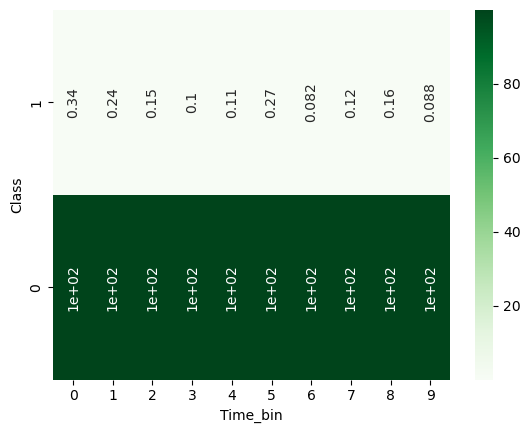

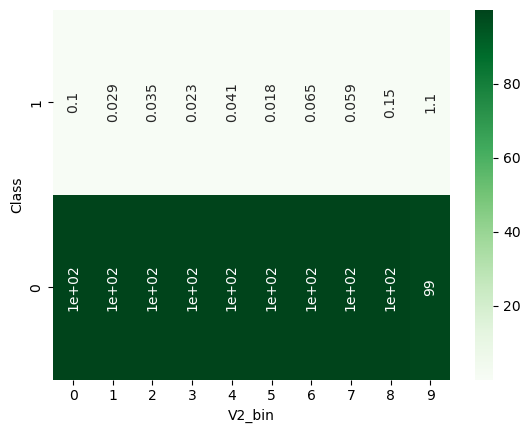

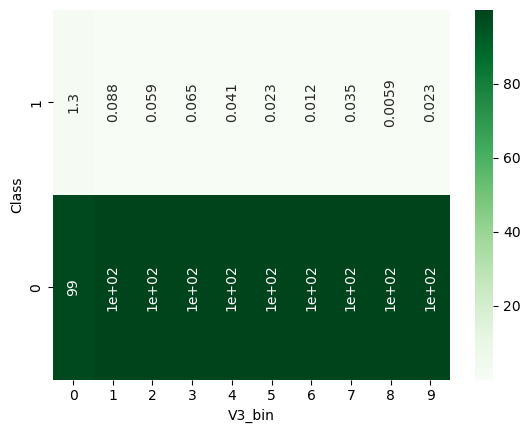

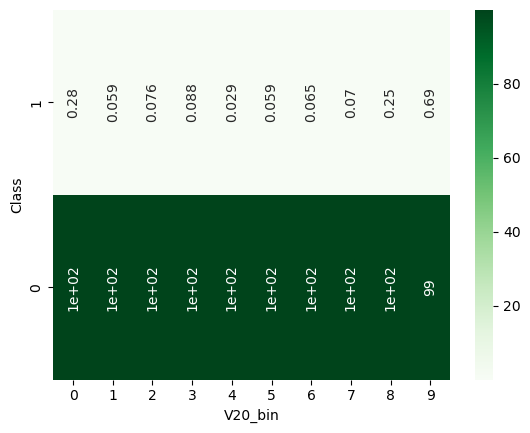

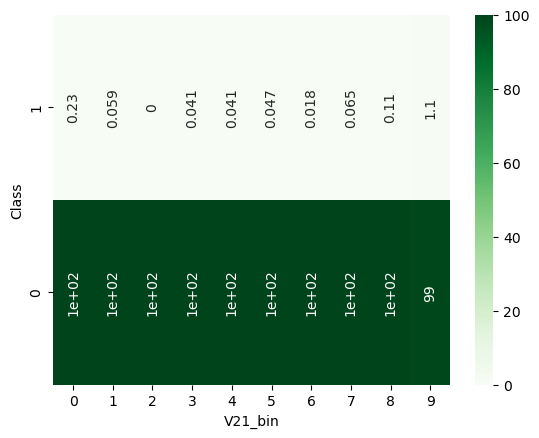

In [49]:
for name in ["Time_bin", "V2_bin", "V3_bin", "V20_bin", "V21_bin"]:
    room_t = pd.DataFrame(pd.crosstab(re_data['Class'], re_data[name], normalize='columns'))
    room_t = room_t * 100

    ax = sns.heatmap(room_t, annot = True, cmap="Greens", annot_kws={'rotation': 90})
    ax.invert_yaxis()
    plt.show();

### Subset data

In [50]:
new_f('V2_bin_9', '9', 'V14', 'V2_bin')    
new_f('V3_bin_0', '0', 'V14', 'V3_bin')    
new_f('V21_bin_5', '5', 'V14', 'V21_bin')    

## Preprocess the model data

In [51]:
a = list(X_train.columns)
a.sort()
print(a)

X_train = X_train.drop(['Time','V2','V3','V20','V21'], axis = 1)
print(X_train.shape)

['Log_Amount', 'Time', 'Time_bin', 'V1', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V2', 'V20', 'V20_bin', 'V21', 'V21_bin', 'V21_bin_5', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V2_bin', 'V2_bin_9', 'V3', 'V3_bin', 'V3_bin_0', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'feature_1', 'feature_2', 'feature_3']
(170235, 36)


In [52]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

[]


In [53]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)
vif.sort_values(['VIF'], ascending = False)

[]


,Features,VIF
24,Log_Amount,5.527821
26,feature_2,5.353097
11,V14,2.696875
28,V2_bin_9,2.634886
29,V3_bin_0,2.579807
25,feature_1,2.008406
14,V17,1.394589
9,V12,1.381564
8,V11,1.216218
13,V16,1.167840


[]


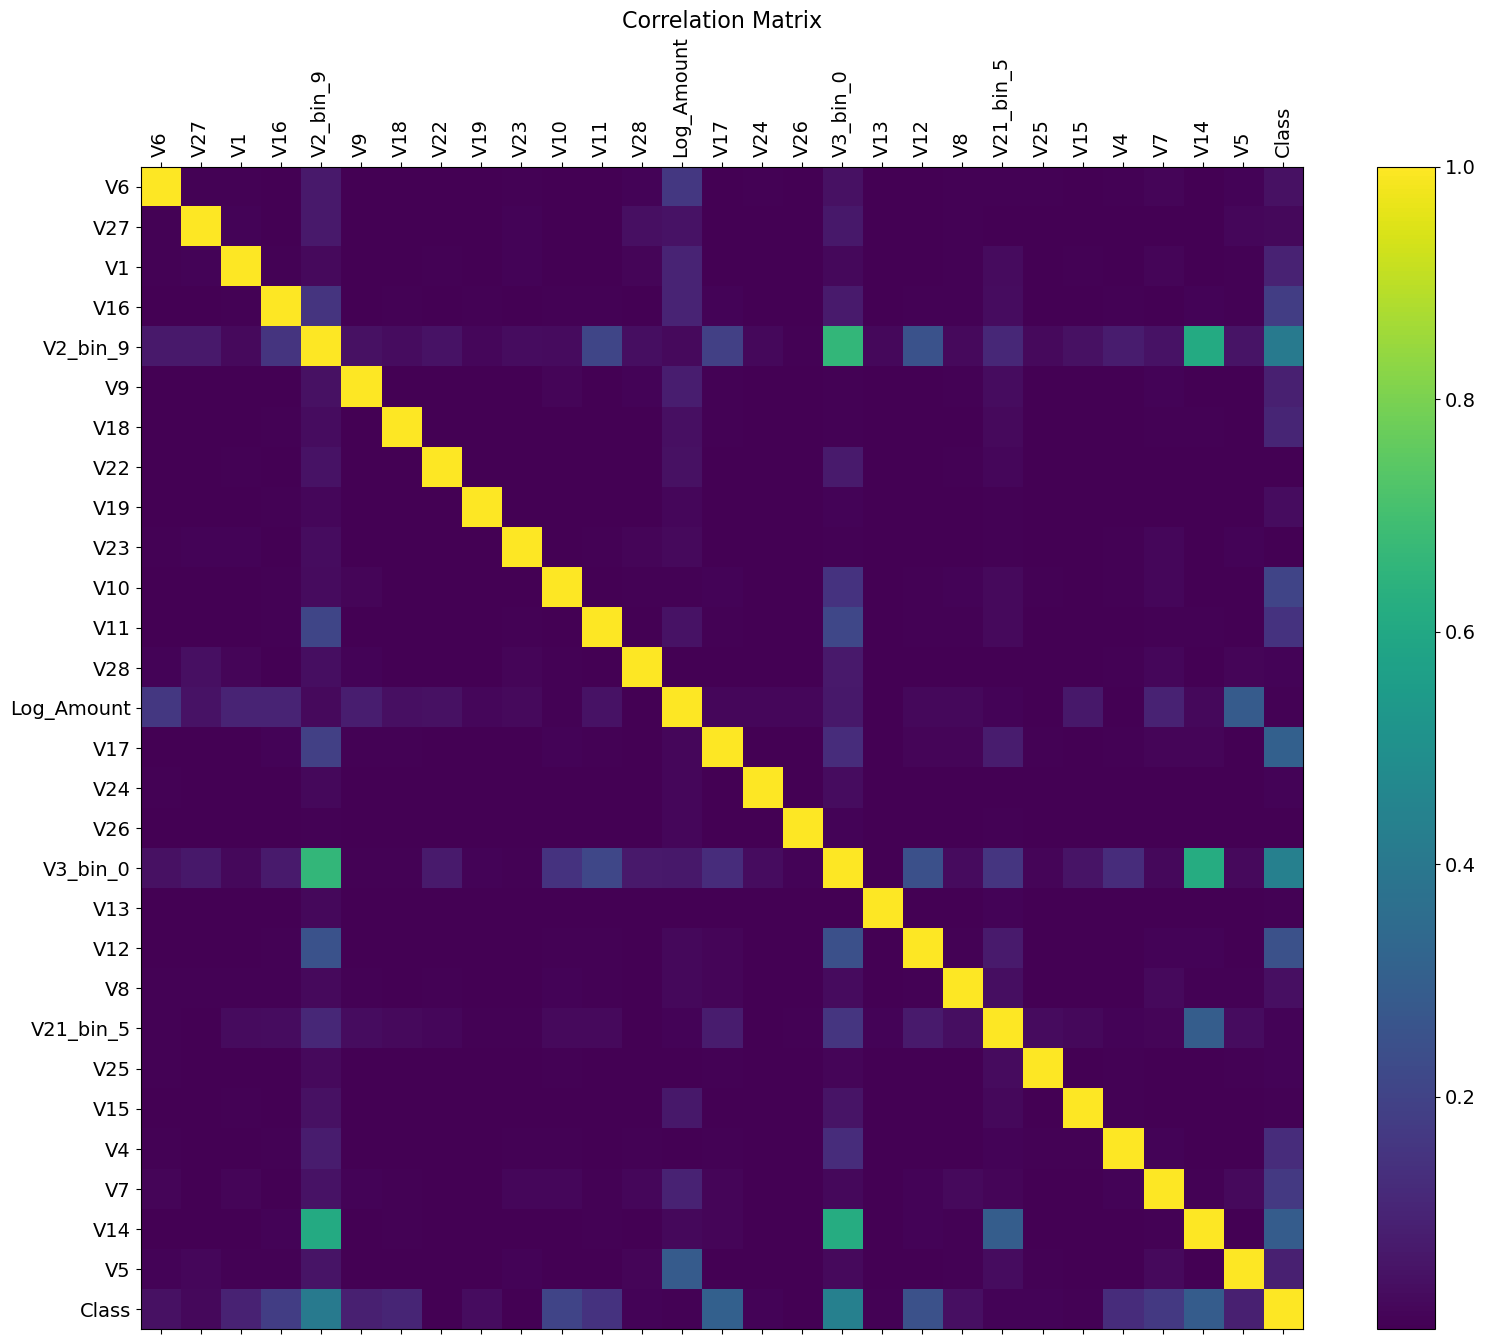

In [54]:
###################
### Correlation ###
###################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [55]:
#####################
### MinMax scaler ###
#####################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###

print(
    f'Data min:max {num_data_train.min().min(),num_data_train.max().max()}')

(170235, 28)
(170235, 28)
(113491, 28)
Data min:max (0.0, 1.0000000000000002)


In [56]:
################################### 
### High cardinality adjustment ###
################################### 

cat_cols = list(X_train.select_dtypes(include=['object']))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if '_bin' in col])))

card_vars = []
cat_data = X_train[cat_cols]
cat_data_vals = cat_data.copy()
for i in range(cat_data.shape[1]):
    print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))        
    if (len(list(set(cat_data.iloc[:,i]))) > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))        

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')        
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        cat_data_vals.loc[~cat_data_vals[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        
    elif cat_data.iloc[:,i].nunique() > 100:
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))     
        card_vars.append(cat_data.columns[i])

print(card_vars)

[]


In [57]:
########################
### One hot encoding ###
########################

cat_cols = list(X_train.select_dtypes(include=['object']))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if '_bin' in col])))

ohe_cols = (list(set(cat_cols) - set(['Education','EnvironmentSatisfaction','JobInvolvement',
                                      'JobSatisfaction','WorkLifeBalance','RelationshipSatisfaction',
                                      'PerformanceRating', 'Age_bin','MonthlyRate_bin','MonthlyIncome_bin',
                                      'DailyRate_bin', 'HourlyRate_bin'])))


ohe = OneHotEncoder()
print(X_train.shape)
# (357127, 56)

### Train ###

ohe.fit(X_train[ohe_cols])
colnames = ohe.get_feature_names_out(ohe_cols)

cat_data_train = ohe_dset(X_train,ohe_cols)  ### Train ###

for name in list(cat_data_train.columns):
    cat_data_train[name] = cat_data_train[name].astype(int)

cat_data_test = ohe_dset(X_test,ohe_cols)    ### Test ###

print(cat_data_train.shape)
cat_data_train.head()

print(
    f'Data min:max {cat_data_train.min().min(),cat_data_train.max().max()}')

(170235, 36)
(170235, 0)
(113491, 0)
(170235, 0)
Data min:max (nan, nan)


In [58]:
print([col for col in X_train.columns if '_bin' in col])
for name in ['Time_bin', 'V2_bin', 'V3_bin', 'V20_bin', 'V21_bin']:
    print(name, list(set(X_train[name])))

['Time_bin', 'V2_bin', 'V3_bin', 'V20_bin', 'V21_bin', 'V2_bin_9', 'V3_bin_0', 'V21_bin_5']
Time_bin ['1', '5', '4', '2', '0', '6', '8', '3', '7', '9']
V2_bin ['1', '4', '5', '2', '0', '6', '8', '3', '7', '9']
V3_bin ['1', '5', '4', '2', '0', '6', '8', '3', '7', '9']
V20_bin ['1', '4', '5', '2', '0', '6', '8', '3', '7', '9']
V21_bin ['1', '5', '2', '4', '0', '6', '8', '3', '7', '9']


In [59]:
ordinal_encoder_bin = OrdinalEncoder(categories=[['Missing','0','1','2','3','4','5','6','7','8','9']])
ordinal_encoder_bin.fit(pd.DataFrame(X_train['Time_bin']))
ord_data_train = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['Time_bin'])),columns = ['Time_bin'])

ordinal_encoder_bin.fit(pd.DataFrame(X_train['V2_bin']))
ord_data_train['V2_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['V2_bin'])))

ordinal_encoder_bin.fit(pd.DataFrame(X_train['V3_bin']))
ord_data_train['V3_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['V3_bin'])))

ordinal_encoder_bin.fit(pd.DataFrame(X_train['V20_bin']))
ord_data_train['V20_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['V20_bin'])))

ordinal_encoder_bin.fit(pd.DataFrame(X_train['V21_bin']))
ord_data_train['V21_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['V21_bin'])))

for name in ['Time_bin', 'V2_bin', 'V3_bin', 'V20_bin', 'V21_bin']:
    ord_data_train[name] = ord_data_train[name].astype(int)

transformer_train_o = MinMaxScaler().fit(ord_data_train)
ord_data_train = pd.DataFrame(transformer_train_o.transform(ord_data_train))
ord_data_train.columns = ['Time_bin', 'V2_bin', 'V3_bin', 'V20_bin', 'V21_bin']

print(
    f'Training data min:max {ord_data_train.min().min(),ord_data_train.max().max()}')

ord_data_test = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['Time_bin'])), columns = ['Time_bin'])
ord_data_test['V2_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['V2_bin'])))
ord_data_test['V3_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['V3_bin'])))
ord_data_test['V20_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['V20_bin'])))
ord_data_test['V21_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['V21_bin'])))


for name in ['Time_bin', 'V2_bin', 'V3_bin', 'V20_bin', 'V21_bin']:
    ord_data_test[name] = ord_data_test[name].astype(int)

transformer_test_o = MinMaxScaler().fit(ord_data_test)
ord_data_test = pd.DataFrame(transformer_test_o.transform(ord_data_test))
ord_data_test.columns = ['Time_bin', 'V2_bin', 'V3_bin', 'V20_bin', 'V21_bin']

print(
    f'Test data min:max {ord_data_test.min().min(),ord_data_test.max().max()}')

ord_data_test.head()

Training data min:max (0.0, 1.0)
Test data min:max (0.0, 1.0)


The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Time_bin
Feature names seen at fit time, yet now missing:
- V21_bin

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- V2_bin
Feature names seen at fit time, yet now missing:
- V21_bin

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- V3_bin
Feature names seen at fit time, yet now missing:
- V21_bin

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- V20_bin
Feature names seen at fit time, yet now missing:
- V21_bin



,Time_bin,V2_bin,V3_bin,V20_bin,V21_bin
0,0.7,0.7,0.333333,0.1,0.9
1,0.3,0.9,0.333333,0.2,0.6
2,0.1,0.1,1.000000,1.0,1.0
3,0.7,0.2,0.333333,0.7,1.0
4,0.5,0.9,0.777778,0.6,0.3


In [60]:
bin_data_train = X_train[[col for col in X_train.columns if 'feature_' in col]]
bin_data_test = X_test[[col for col in X_test.columns if 'feature_' in col]]
bin_data_train.head()

,feature_1,feature_2,feature_3
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [61]:
###########################
### Bring data together ###
###########################

print(bin_data_train.shape, num_data_train.shape, ord_data_train.shape)
bin_data_train = bin_data_train.reset_index()
num_data_train = num_data_train.reset_index()
ord_data_train = ord_data_train.reset_index()

X_train_mod = pd.concat([bin_data_train,num_data_train],axis = 1)
X_train_mod = pd.concat([X_train_mod,ord_data_train],axis = 1)
print(X_train_mod.shape)

print(bin_data_test.shape, num_data_test.shape)
bin_data_test = bin_data_test.reset_index()
num_data_test = num_data_test.reset_index()
X_test_mod = pd.concat([bin_data_test,num_data_test],axis = 1)
X_test_mod = pd.concat([X_test_mod,ord_data_test],axis = 1)
print(X_test_mod.shape)

#cat_data_oot = cat_data_oot.reset_index()
#num_data_oot = num_data_oot.reset_index()
#X_oot = pd.concat([cat_data_oot,num_data_oot],axis = 1)
print(X_train_mod.shape, X_test_mod.shape)
# (170235, 39) (113491, 38)

(170235, 3) (170235, 28) (170235, 5)
(170235, 39)
(113491, 3) (113491, 28)
(113491, 38)
(170235, 39) (113491, 38)


In [62]:
####################################################
### Check that train/test sets have same columns ###
####################################################

try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('index')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod
    
try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('level_0')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod

mod_cols = (list(set(list(X_train_mod.columns)) - set(['index'])))
X_train_mod = X_train_mod[mod_cols]
miss_lst = list(set(list(X_train_mod.columns)) - set(list(X_test_mod.columns)))

for name in miss_lst:
    X_test_mod[name] = 0
X_test_mod = X_test_mod[list(X_train_mod.columns)]

drop_test_lst = list(set(list(X_test_mod.columns)) - set(list(X_train_mod.columns)))
X_test_mod = X_test_mod.drop(drop_test_lst, axis = 1)


print(X_train_mod.shape, X_test_mod.shape)
# (64215, 105) (42811, 135) (10148, 107)


(170235, 36) (113491, 36)


In [63]:
a = list(X_train_mod.columns)
a.sort()
print(a)

['Log_Amount', 'Time_bin', 'V1', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20_bin', 'V21_bin', 'V21_bin_5', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V2_bin', 'V2_bin_9', 'V3_bin', 'V3_bin_0', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'feature_1', 'feature_2', 'feature_3']


## Models

In [ ]:
print(X_train_mod.shape)
print(len(y_train))

In [76]:
############################################
### Check the accuracy on all the models ###
############################################

models = select_model(X_train_mod, y_train)

models.head(20)

# LGBMClassifier	0.26	0.960324  
# DummyClassifier	0.04	0.500000
# ExtraTreeClassifier	0.07	0.877337
# RidgeClassifier	0.08	0.96266
# BernoulliNB	0.07	0.900442
# SGDClassifier	0.11	0.972112
# XGBClassifier	4.21	0.973219
# AdaBoostClassifier	5.86	0.966523
# CatBoostClassifier	2.42	0.962919
# KNeighborsClassifier	27.25	0.901989
# DecisionTreeClassifier	1.71	0.870446

`use_label_encoder` is deprecated in 1.7.0.
 60%|██████    | 3/5 [35:31<22:15, 667.51s/it] `use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
100%|██████████| 5/5 [41:26<00:00, 497.36s/it]


,model,run_time,accuracy
0,XGBClassifier,4.21,0.973219
1,AdaBoostClassifier,5.86,0.966523
2,CatBoostClassifier,2.42,0.962919
3,KNeighborsClassifier,27.25,0.901989
4,DecisionTreeClassifier,1.71,0.870446


In [46]:
accuracy_lst_lr = []
precision_lst_lr = []
recall_lst_lr = []
f1_lst_lr = []
auc_lst_lr = []

log_reg_params = {"penalty": ['none', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, cv=3, verbose = 2)

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train, test in sss.split(num_data_train, y_train):
    pipeline_lr = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), grid_log_reg) 
    model_lr = pipeline_lr.fit(num_data_train.iloc[train], y_train.iloc[train])
    best_est_lr = grid_log_reg.best_estimator_
    prediction_lr = best_est_lr.predict(num_data_train.iloc[test])
    
    accuracy_lst_lr.append(pipeline_lr.score(num_data_train.iloc[test], y_train.iloc[test]))
    precision_lst_lr.append(precision_score(y_train.iloc[test], prediction_lr))
    recall_lst_lr.append(recall_score(y_train.iloc[test], prediction_lr))
    f1_lst_lr.append(f1_score(y_train.iloc[test], prediction_lr))
    auc_lst_lr.append(roc_auc_score(y_train.iloc[test], prediction_lr))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_lr)))
print("precision: {}".format(np.mean(precision_lst_lr)))
print("recall: {}".format(np.mean(recall_lst_lr)))
print("f1: {}".format(np.mean(f1_lst_lr)))
print('---' * 45)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..............................C=0.001, penalty=none; total time=   1.9s
[CV] END ................................C=0.001, penalty=l2; total time=   0.6s
[CV] END ................................C=0.001, penalty=l2; total time=   0.5s
[CV] END ................................C=0.001, penalty=l2; total time=   0.6s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=0.01, penalty=none; total time=   1.8s
[CV] END .................................C=0.01, penalty=l2; total time=   1.5s
[CV] END .................................C=0.01, penalty=l2; total time=   1.2s
[CV] END .................................C=0.01, penalty=l2; total time=   1.6s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=0.1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ....................................C=1, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=10, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..................................C=100, penalty=l2; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=1000, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting 3 folds for each of 14 candidates, totalling 42 fits


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..............................C=0.001, penalty=none; total time=   1.8s
[CV] END ................................C=0.001, penalty=l2; total time=   0.7s
[CV] END ................................C=0.001, penalty=l2; total time=   0.8s
[CV] END ................................C=0.001, penalty=l2; total time=   0.8s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=0.01, penalty=none; total time=   1.8s
[CV] END .................................C=0.01, penalty=l2; total time=   1.4s
[CV] END .................................C=0.01, penalty=l2; total time=   1.5s
[CV] END .................................C=0.01, penalty=l2; total time=   1.1s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=0.1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   1.7s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ....................................C=1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=10, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..................................C=100, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   2.1s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=1000, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=1000, penalty=l2; total time=   1.7s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting 3 folds for each of 14 candidates, totalling 42 fits


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   2.1s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..............................C=0.001, penalty=none; total time=   1.9s
[CV] END ................................C=0.001, penalty=l2; total time=   0.7s
[CV] END ................................C=0.001, penalty=l2; total time=   0.7s
[CV] END ................................C=0.001, penalty=l2; total time=   0.6s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=0.01, penalty=none; total time=   1.9s
[CV] END .................................C=0.01, penalty=l2; total time=   1.4s
[CV] END .................................C=0.01, penalty=l2; total time=   1.4s
[CV] END .................................C=0.01, penalty=l2; total time=   1.3s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=0.1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   2.1s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ....................................C=1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=10, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...................................C=10, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..................................C=100, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=1000, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting 3 folds for each of 14 candidates, totalling 42 fits


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..............................C=0.001, penalty=none; total time=   1.8s
[CV] END ................................C=0.001, penalty=l2; total time=   0.7s
[CV] END ................................C=0.001, penalty=l2; total time=   0.7s
[CV] END ................................C=0.001, penalty=l2; total time=   0.8s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=0.01, penalty=none; total time=   1.8s
[CV] END .................................C=0.01, penalty=l2; total time=   1.4s
[CV] END .................................C=0.01, penalty=l2; total time=   1.5s
[CV] END .................................C=0.01, penalty=l2; total time=   1.4s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=0.1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.8s
[CV] END ..................................C=0.1, penalty=l2; total time=   1.6s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   1.7s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ....................................C=1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=10, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..................................C=100, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=1000, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting 3 folds for each of 14 candidates, totalling 42 fits


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..............................C=0.001, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..............................C=0.001, penalty=none; total time=   2.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.7s
[CV] END ................................C=0.001, penalty=l2; total time=   0.7s
[CV] END ................................C=0.001, penalty=l2; total time=   0.6s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=0.01, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=0.01, penalty=none; total time=   1.9s
[CV] END .................................C=0.01, penalty=l2; total time=   1.2s
[CV] END .................................C=0.01, penalty=l2; total time=   1.3s
[CV] END .................................C=0.01, penalty=l2; total time=   1.8s


Setting penalty='none' will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=0.1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=0.1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=0.1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=1, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ....................................C=1, penalty=l2; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ....................................C=1, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END .................................C=10, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=10, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...................................C=10, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ................................C=100, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ................................C=100, penalty=none; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ..................................C=100, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ..................................C=100, penalty=l2; total time=   1.9s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Setting penalty='none' will ignore the C and l1_ratio parameters


[CV] END ...............................C=1000, penalty=none; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END ...............................C=1000, penalty=none; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   2.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.8s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .................................C=1000, penalty=l2; total time=   1.8s
---------------------------------------------------------------------------------------------------------------------------------------



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


NameError: name 'accuracy_lst' is not defined

In [48]:
print(best_est_lr)

LogisticRegression(C=100)

In [49]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [68]:
accuracy_lst_rf = []
precision_lst_rf = []
recall_lst_rf = []
f1_lst_rf = []
auc_lst_rf = []

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

rf_params = {"max_features": [10, 20, 30], 
             "n_estimators": [100, 200, 300],
             'max_depth': [3, 5, 7, 9]}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, verbose = 2)

for train, test in sss.split(num_data_train, y_train):
    pipeline_rf = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), grid_rf) 
    model_rf = pipeline_rf.fit(num_data_train.iloc[train], y_train.iloc[train])
    best_est_rf = grid_rf.best_estimator_
    prediction_rf = best_est_rf.predict(num_data_train.iloc[test])
    
    accuracy_lst_rf.append(pipeline_rf.score(num_data_train.iloc[test], y_train.iloc[test]))
    precision_lst_rf.append(precision_score(y_train.iloc[test], prediction_rf))
    recall_lst_rf.append(recall_score(y_train.iloc[test], prediction_rf))
    f1_lst_rf.append(f1_score(y_train.iloc[test], prediction_rf))
    auc_lst_rf.append(roc_auc_score(y_train.iloc[test], prediction_rf))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_rf)))
print("precision: {}".format(np.mean(precision_lst_rf)))
print("recall: {}".format(np.mean(recall_lst_rf)))
print("f1: {}".format(np.mean(f1_lst_rf)))
print('---' * 45)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END .....max_depth=3, max_features=10, n_estimators=100; total time=  50.8s
[CV] END .....max_depth=3, max_features=10, n_estimators=100; total time=  52.4s
[CV] END .....max_depth=3, max_features=10, n_estimators=100; total time=  50.8s


KeyboardInterrupt: 

In [ ]:
print(best_est_rf)

In [69]:
accuracy_lst_xgb = []
precision_lst_xgb = []
recall_lst_xgb = []
f1_lst_xgb = []
auc_lst_xgb = []

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

xgb_params = {"n_estimators": (150,400),
              "learning_rate": (0.01, 0.2),
              "subsample":(0.6, 1.0),
              "max_bin":(150,300),
              "eval_metric":'logloss',
              "objective":'binary:logistic'
}

grid_xgb = GridSearchCV(XGBClassifier(), xgb_params, cv=3, verbose = 2)

for train, test in sss.split(num_data_train, y_train):
    pipeline_xgb = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), grid_xgb) 
    model_xgb = pipeline_xgb.fit(num_data_train.iloc[train], y_train.iloc[train])
    best_est_xgb = grid_xgb.best_estimator_
    prediction_xgb = best_est_xgb.predict(num_data_train.iloc[test])
    
    accuracy_lst_xgb.append(pipeline_xgb.score(num_data_train.iloc[test], y_train.iloc[test]))
    precision_lst_xgb.append(precision_score(y_train.iloc[test], prediction_xgb))
    recall_lst_xgb.append(recall_score(y_train.iloc[test], prediction_xgb))
    f1_lst_xgb.append(f1_score(y_train.iloc[test], prediction_xgb))
    auc_lst_xgb.append(roc_auc_score(y_train.iloc[test], prediction_xgb))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_xgb)))
print("precision: {}".format(np.mean(precision_lst_xgb)))
print("recall: {}".format(np.mean(recall_lst_xgb)))
print("f1: {}".format(np.mean(f1_lst_xgb)))
print('---' * 45)

Fitting 3 folds for each of 256 candidates, totalling 768 fits
[11:13:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "depth", "l2_leaf_reg", "model_size_reg", "num_leaves" } are not used.

[CV] END depth=2, l2_leaf_reg=2, learning_rate=0.01, max_bin=150, model_size_reg=0, n_estimators=150, num_leaves=16, subsample=0.6; total time=  39.6s
[11:13:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "depth", "l2_leaf_reg", "model_size_reg", "num_leaves" } are not used.

[CV] END depth=2, l2_leaf_reg=2, learning_rate=0.01, max_bin=150, model_size_reg=0, n_estimators=150, num_leaves=16, subsample=0.6; total time=  38.7s
[11:14:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "depth", "l2_leaf

KeyboardInterrupt: 

In [ ]:
print(best_est_xgb)

In [72]:
accuracy_lst_cbc = []
precision_lst_cbc = []
recall_lst_cbc = []
f1_lst_cbc = []
auc_lst_cbc = []

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

cbc_params = {'depth'         : [4,5,6,7,8,9, 10],                 
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
}

grid_cbc = GridSearchCV(CatBoostClassifier(silent=True), cbc_params, cv=3, verbose = 2)

for train, test in sss.split(num_data_train, y_train):
    pipeline_cbc = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), grid_cbc) 
    model_cbc = pipeline_cbc.fit(num_data_train.iloc[train], y_train.iloc[train])
    best_est_cbc = grid_cbc.best_estimator_
    prediction_cbc = best_est_cbc.predict(num_data_train.iloc[test])
    
    accuracy_lst_cbc.append(pipeline_cbc.score(num_data_train.iloc[test], y_train.iloc[test]))
    precision_lst_cbc.append(precision_score(y_train.iloc[test], prediction_cbc))
    recall_lst_cbc.append(recall_score(y_train.iloc[test], prediction_cbc))
    f1_lst_cbc.append(f1_score(y_train.iloc[test], prediction_cbc))
    auc_lst_cbc.append(roc_auc_score(y_train.iloc[test], prediction_cbc))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_cbc)))
print("precision: {}".format(np.mean(precision_lst_cbc)))
print("recall: {}".format(np.mean(recall_lst_cbc)))
print("f1: {}".format(np.mean(f1_lst_cbc)))
print('---' * 45)

Fitting 3 folds for each of 280 candidates, totalling 840 fits
[CV] END .........depth=4, iterations=10, learning_rate=0.01; total time=   0.6s
[CV] END .........depth=4, iterations=10, learning_rate=0.01; total time=   0.4s
[CV] END .........depth=4, iterations=10, learning_rate=0.01; total time=   0.4s
[CV] END .........depth=4, iterations=10, learning_rate=0.02; total time=   0.4s
[CV] END .........depth=4, iterations=10, learning_rate=0.02; total time=   0.4s
[CV] END .........depth=4, iterations=10, learning_rate=0.02; total time=   0.4s
[CV] END .........depth=4, iterations=10, learning_rate=0.03; total time=   0.4s
[CV] END .........depth=4, iterations=10, learning_rate=0.03; total time=   0.4s
[CV] END .........depth=4, iterations=10, learning_rate=0.03; total time=   0.4s
[CV] END .........depth=4, iterations=10, learning_rate=0.04; total time=   0.4s
[CV] END .........depth=4, iterations=10, learning_rate=0.04; total time=   0.4s
[CV] END .........depth=4, iterations=10, lear

[CV] END .........depth=4, iterations=90, learning_rate=0.02; total time=   1.8s
[CV] END .........depth=4, iterations=90, learning_rate=0.03; total time=   1.9s
[CV] END .........depth=4, iterations=90, learning_rate=0.03; total time=   1.9s
[CV] END .........depth=4, iterations=90, learning_rate=0.03; total time=   2.0s
[CV] END .........depth=4, iterations=90, learning_rate=0.04; total time=   2.2s
[CV] END .........depth=4, iterations=90, learning_rate=0.04; total time=   1.9s
[CV] END .........depth=4, iterations=90, learning_rate=0.04; total time=   1.9s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   2.1s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   2.2s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   2.4s
[CV] END ........depth=4, iterations=100, learning_rate=0.02; total time=   2.0s
[CV] END ........depth=4, iterations=100, learning_rate=0.02; total time=   2.1s
[CV] END ........depth=4, it

[CV] END .........depth=5, iterations=70, learning_rate=0.04; total time=   1.7s
[CV] END .........depth=5, iterations=80, learning_rate=0.01; total time=   2.2s
[CV] END .........depth=5, iterations=80, learning_rate=0.01; total time=   2.3s
[CV] END .........depth=5, iterations=80, learning_rate=0.01; total time=   2.3s
[CV] END .........depth=5, iterations=80, learning_rate=0.02; total time=   2.2s
[CV] END .........depth=5, iterations=80, learning_rate=0.02; total time=   2.0s
[CV] END .........depth=5, iterations=80, learning_rate=0.02; total time=   1.9s
[CV] END .........depth=5, iterations=80, learning_rate=0.03; total time=   1.9s
[CV] END .........depth=5, iterations=80, learning_rate=0.03; total time=   2.5s
[CV] END .........depth=5, iterations=80, learning_rate=0.03; total time=   2.9s
[CV] END .........depth=5, iterations=80, learning_rate=0.04; total time=   1.9s
[CV] END .........depth=5, iterations=80, learning_rate=0.04; total time=   1.9s
[CV] END .........depth=5, i

[CV] END .........depth=6, iterations=60, learning_rate=0.02; total time=   1.7s
[CV] END .........depth=6, iterations=60, learning_rate=0.03; total time=   1.8s
[CV] END .........depth=6, iterations=60, learning_rate=0.03; total time=   1.9s
[CV] END .........depth=6, iterations=60, learning_rate=0.03; total time=   1.8s
[CV] END .........depth=6, iterations=60, learning_rate=0.04; total time=   1.9s
[CV] END .........depth=6, iterations=60, learning_rate=0.04; total time=   2.1s
[CV] END .........depth=6, iterations=60, learning_rate=0.04; total time=   1.9s
[CV] END .........depth=6, iterations=70, learning_rate=0.01; total time=   2.1s
[CV] END .........depth=6, iterations=70, learning_rate=0.01; total time=   2.1s
[CV] END .........depth=6, iterations=70, learning_rate=0.01; total time=   2.2s
[CV] END .........depth=6, iterations=70, learning_rate=0.02; total time=   2.3s
[CV] END .........depth=6, iterations=70, learning_rate=0.02; total time=   2.2s
[CV] END .........depth=6, i

[CV] END .........depth=7, iterations=40, learning_rate=0.04; total time=   1.5s
[CV] END .........depth=7, iterations=50, learning_rate=0.01; total time=   1.8s
[CV] END .........depth=7, iterations=50, learning_rate=0.01; total time=   1.7s
[CV] END .........depth=7, iterations=50, learning_rate=0.01; total time=   1.9s
[CV] END .........depth=7, iterations=50, learning_rate=0.02; total time=   2.0s
[CV] END .........depth=7, iterations=50, learning_rate=0.02; total time=   1.8s
[CV] END .........depth=7, iterations=50, learning_rate=0.02; total time=   1.8s
[CV] END .........depth=7, iterations=50, learning_rate=0.03; total time=   1.8s
[CV] END .........depth=7, iterations=50, learning_rate=0.03; total time=   1.8s
[CV] END .........depth=7, iterations=50, learning_rate=0.03; total time=   2.0s
[CV] END .........depth=7, iterations=50, learning_rate=0.04; total time=   1.8s
[CV] END .........depth=7, iterations=50, learning_rate=0.04; total time=   1.7s
[CV] END .........depth=7, i

[CV] END .........depth=8, iterations=30, learning_rate=0.02; total time=   1.4s
[CV] END .........depth=8, iterations=30, learning_rate=0.03; total time=   1.4s
[CV] END .........depth=8, iterations=30, learning_rate=0.03; total time=   1.5s
[CV] END .........depth=8, iterations=30, learning_rate=0.03; total time=   1.5s
[CV] END .........depth=8, iterations=30, learning_rate=0.04; total time=   1.4s
[CV] END .........depth=8, iterations=30, learning_rate=0.04; total time=   1.3s
[CV] END .........depth=8, iterations=30, learning_rate=0.04; total time=   1.4s
[CV] END .........depth=8, iterations=40, learning_rate=0.01; total time=   1.7s
[CV] END .........depth=8, iterations=40, learning_rate=0.01; total time=   1.8s
[CV] END .........depth=8, iterations=40, learning_rate=0.01; total time=   1.9s
[CV] END .........depth=8, iterations=40, learning_rate=0.02; total time=   1.7s
[CV] END .........depth=8, iterations=40, learning_rate=0.02; total time=   1.8s
[CV] END .........depth=8, i

[CV] END .........depth=9, iterations=10, learning_rate=0.04; total time=   0.9s
[CV] END .........depth=9, iterations=20, learning_rate=0.01; total time=   1.6s
[CV] END .........depth=9, iterations=20, learning_rate=0.01; total time=   1.4s
[CV] END .........depth=9, iterations=20, learning_rate=0.01; total time=   1.4s
[CV] END .........depth=9, iterations=20, learning_rate=0.02; total time=   1.5s
[CV] END .........depth=9, iterations=20, learning_rate=0.02; total time=   1.4s
[CV] END .........depth=9, iterations=20, learning_rate=0.02; total time=   1.3s
[CV] END .........depth=9, iterations=20, learning_rate=0.03; total time=   1.4s
[CV] END .........depth=9, iterations=20, learning_rate=0.03; total time=   1.4s
[CV] END .........depth=9, iterations=20, learning_rate=0.03; total time=   1.3s
[CV] END .........depth=9, iterations=20, learning_rate=0.04; total time=   1.3s
[CV] END .........depth=9, iterations=20, learning_rate=0.04; total time=   1.3s
[CV] END .........depth=9, i

[CV] END ........depth=9, iterations=100, learning_rate=0.02; total time=   7.3s
[CV] END ........depth=9, iterations=100, learning_rate=0.03; total time=   6.4s
[CV] END ........depth=9, iterations=100, learning_rate=0.03; total time=   6.0s
[CV] END ........depth=9, iterations=100, learning_rate=0.03; total time=   6.0s
[CV] END ........depth=9, iterations=100, learning_rate=0.04; total time=   5.7s
[CV] END ........depth=9, iterations=100, learning_rate=0.04; total time=   5.8s
[CV] END ........depth=9, iterations=100, learning_rate=0.04; total time=   6.0s
[CV] END ........depth=10, iterations=10, learning_rate=0.01; total time=   1.2s
[CV] END ........depth=10, iterations=10, learning_rate=0.01; total time=   1.2s
[CV] END ........depth=10, iterations=10, learning_rate=0.01; total time=   1.2s
[CV] END ........depth=10, iterations=10, learning_rate=0.02; total time=   1.1s
[CV] END ........depth=10, iterations=10, learning_rate=0.02; total time=   1.2s
[CV] END ........depth=10, i

[CV] END ........depth=10, iterations=80, learning_rate=0.04; total time=   7.8s
[CV] END ........depth=10, iterations=90, learning_rate=0.01; total time=   8.6s
[CV] END ........depth=10, iterations=90, learning_rate=0.01; total time=   9.1s
[CV] END ........depth=10, iterations=90, learning_rate=0.01; total time=   8.1s
[CV] END ........depth=10, iterations=90, learning_rate=0.02; total time=   8.2s
[CV] END ........depth=10, iterations=90, learning_rate=0.02; total time=   8.4s
[CV] END ........depth=10, iterations=90, learning_rate=0.02; total time=   8.4s
[CV] END ........depth=10, iterations=90, learning_rate=0.03; total time=   8.4s
[CV] END ........depth=10, iterations=90, learning_rate=0.03; total time=   8.1s
[CV] END ........depth=10, iterations=90, learning_rate=0.03; total time=   8.1s
[CV] END ........depth=10, iterations=90, learning_rate=0.04; total time=   8.6s
[CV] END ........depth=10, iterations=90, learning_rate=0.04; total time=   8.1s
[CV] END ........depth=10, i

NameError: name 'prediction' is not defined

In [71]:
CatBoostClassifier().get_params().keys()

dict_keys([])

In [ ]:
print(best_est_cbc)

In [ ]:
###########################################
### Assess the performance of the model ###
###########################################

models_optimized = [('CatBoost_optimized', cboost_model_hy),
                    ('LGBM_optimized', lbgm_model_hy)]

dset = [('Training', X_train, y_train),
        ('Test', X_test, y_test),
        ('OOT', X_oot, y_oot)]

results_fin = pd.DataFrame(columns = ['Model','Metrics','Training','Test'])

for name, model in tqdm(models_optimized):

    results = pd.DataFrame(['ROC/AUC:','Accuracy:','F1 score:'],
                           columns = ['Metrics'])

    for name_dset, X_dset, y_dset in tqdm(dset):

        #####################
        ### Fit the model ###
        #####################

        if name != 'LGBM_optimized':

            if name_dset == 'Training':
                model.fit(X_dset, y_dset)

            y_pred_p = model.predict_proba(X_dset)
            y_pred_p1 = y_pred_p[:,1]

        y_pred_hyp = model.predict(X_dset)
        if name == 'LGBM_optimized':
            y_pred_p1 = pd.DataFrame(y_pred_hyp)
            y_pred_hyp = np.rint(y_pred_hyp)

        metric = []
        roc_auc_hyp = roc_auc_score(y_dset, y_pred_hyp)
        metric.append(roc_auc_hyp)
        accuracy_hyp = accuracy_score(y_dset, y_pred_hyp)
        metric.append(accuracy_hyp)
        f1_score_hyp = metrics.f1_score(y_dset, y_pred_hyp)
        metric.append(f1_score_hyp)

        print('ROC/AUC:', roc_auc_hyp)
        print('Accuracy:', accuracy_hyp)
        print('F1 score:', f1_score_hyp)

        print(classification_report(y_dset, y_pred_hyp))

        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_dset, y_pred_hyp)

        cm_as_df = cm2df(cm,['Not churn','Churn'])

        print(confusion_matrix(y_dset, y_pred_hyp))

        results = pd.concat([results,
                             pd.DataFrame(metric,
                                          columns = [name_dset])],
                            axis = 1)

        #################
        ### ROC curve ###
        #################

        fpr, tpr, _ = metrics.roc_curve(y_dset,  y_pred_p1)

        plt.plot(fpr,
                 tpr,
                 label = "AUC=" + str(round(roc_auc_hyp,2)))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()

        roc_data = pd.concat([pd.DataFrame(fpr),
                              pd.DataFrame(tpr)],axis = 1)
        roc_data.columns = ['FPR','TPR']
        roc_data = roc_data.reset_index()

        ###############################
        ### Precision Recall curves ###
        ###############################

        precision, recall, thresholds = precision_recall_curve(y_dset,
                                                               y_pred_p1)

        ### calculate F1 score ###

        f1 = metrics.f1_score(y_dset, y_pred_hyp)

        ### summarize scores ###

        print('Model: f1 = %.3f roc_auc = %.3f' % (f1, roc_auc_hyp))

        ### plot the precision-recall curves ###

        no_skill = len(y_dset[y_dset == 1]) / len(y_dset)

        plt.plot([0, 1],
                 [no_skill, no_skill],
                 linestyle='--',
                 label='No Skill')
        plt.plot(recall,
                 precision,
                 marker='.',
                 label = name)
        plt.xlabel('Recall')
        plt.ylabel('Precision')

        ### show the legend ###
        plt.legend()
        plt.show()

        pr_data = pd.concat([pd.DataFrame(precision),
                              pd.DataFrame(recall)],axis = 1)
        pr_data.columns = ['Precision','Recall']
        pr_data = pr_data.reset_index()

        results['Model'] = name

    results_fin = pd.concat([results_fin,
                             results],
                            axis = 0)

### Shapley values

In [148]:
explainer = shap.TreeExplainer(lbgm_model_hy)
shap_values = explainer.shap_values(X_train_mod)

# visualize the first prediction's explanation 
shap.initjs()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


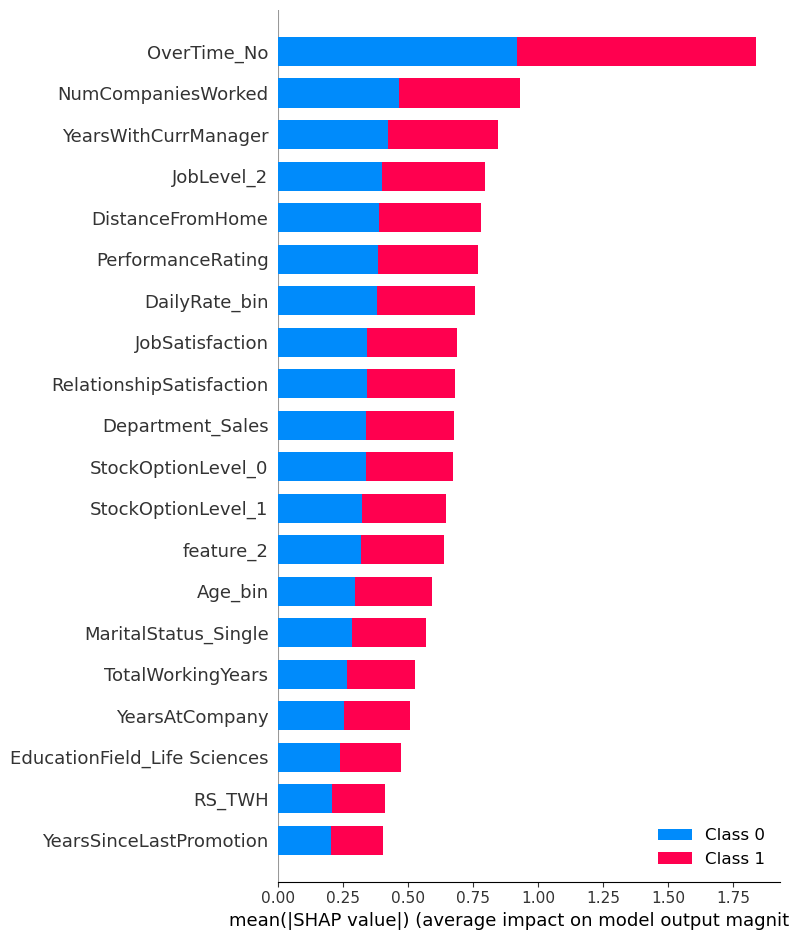

In [149]:
shap_values = shap.TreeExplainer(lbgm_model_hy).shap_values(X_train_mod)
shap.summary_plot(shap_values, X_train_mod, plot_type="bar");

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


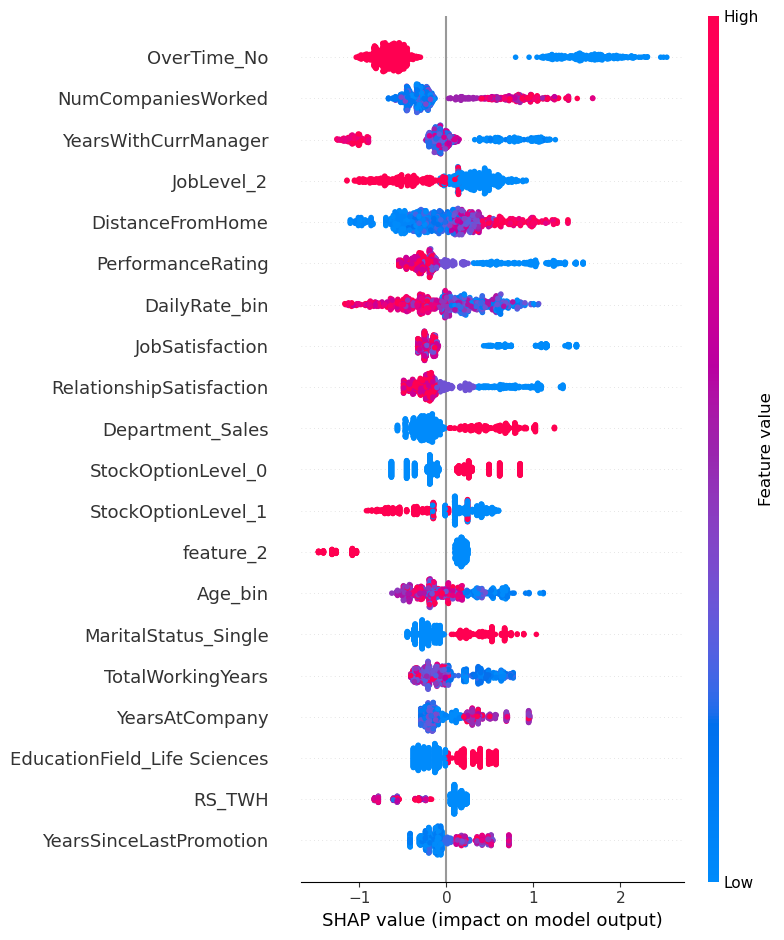

In [150]:
shap.summary_plot(shap_values[1], X_train_mod, plot_type='dot')

In [151]:
a = list(X_train_mod.columns)
a.sort()
print(a)

['Age_bin', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'DailyRate_bin', 'Department_Human_Resources', 'Department_Research__Development', 'Department_Sales', 'DistanceFromHome', 'Education', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'EnvironmentSatisfaction', 'Gender_Female', 'Gender_Male', 'HR_TWH', 'HourlyRate_bin', 'JobInvolvement', 'JobLevel_1', 'JobLevel_2', 'JobLevel_3', 'JobLevel_4', 'JobLevel_5', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'JobSatisfaction', 'LT_TWH', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MonthlyIncome_bin', 'Monthly